In [ ]:
!pip install pmdarima
!pip install workalendar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.4 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732003 sha256=11f92a2606e88b06f17899d6b21b772bbd722572739dcaf30b09b8bf541d5818
  Stored in directory: /root/.cache/pip/wheels/8f/bd/f9/5c4c39b529e0322b08979e1c465e203218bc2cca75d20f7df5
Successfully built pymeeus


In [ ]:
!pip install prophet
!pip install -q --upgrade linear-tree

In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

In [ ]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [ ]:
df = pd.read_csv("/content/historic_demand_2009_2024.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [ ]:
df.sample(n=7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
249674      2023-03-30                 29  25820  26812                 23197   
128944      2016-05-10                  7  21558  23462                 19670   
71224       2013-01-23                 38  54330  55413                 49194   
243726      2022-11-26                 31  28718  35271                 27412   
91644       2014-03-25                  3  28587  30687                 26232   
92655       2014-04-15                  5  26086  28167                 23553   
227691      2021-12-27                 28  33978  34583                 30232   

        embedded_wind_generation  embedded_wind_capacity  \
249674                      2414                    6545   
128944                       935                    4260   
71224                        494                    2085   
243726                      3756                    6545   
91644                       1165                    2524   
92655                        275                    2524   
227691                      1243                    6527   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
249674                       5557                    15316            0  ...   
128944                          0                     9602            0  ...   
71224                           7                     2089           29  ...   
243726                         71                    13861            0  ...   
91644                           0                     4527            0  ...   
92655                           0                     4590            0  ...   
227691                        525                    13080            0  ...   

        britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
249674          1050        -450             -31        471    1095.0   
128944             0         198             284          0       NaN   
71224            512        -251            -250          0       NaN   
243726         -1054         217               0      -1021    -791.0   
91644            999         -70            -178          0       NaN   
92655            999        -157            -261          0       NaN   
227691           637         221               0        412     218.0   

        eleclink_flow  scottish_transfer  viking_flow  greenlink_flow  \
249674          997.0              122.0          0.0             NaN   
128944            NaN                NaN          NaN             NaN   
71224             NaN                NaN          NaN             NaN   
243726        -1023.0                NaN          NaN             NaN   
91644             NaN                NaN          NaN             NaN   
92655             NaN                NaN          NaN             NaN   
227691            0.0                NaN          NaN             NaN   

        is_holiday  
249674           0  
128944           0  
71224            0  
243726           0  
91644            0  
92655            0  
227691           0  

[7 rows x 23 columns]

In [ ]:
df.describe()


settlement_period             nd            tsd  england_wales_demand  \
count      279264.000000  279264.000000  279264.000000         279264.000000   
mean           24.500229   31186.565042   32627.843779          28389.002868   
std            13.853821    7827.270027    7710.008440           7087.628201   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.750000   24908.000000   26582.000000          22677.000000   
50%            24.500000   30495.000000   31782.000000          27756.000000   
75%            36.250000   36913.000000   38096.000000          33615.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             279264.000000           279264.000000   
mean                1270.098774             4447.695772   
std                  966.304596             1957.216235   
min                    0.000000             1403.000000   
25%                  551.000000             2102.000000   
50%                 1016.000000             4831.000000   
75%                 1726.000000             6527.000000   
max                 5930.000000             6622.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              279264.000000            279264.000000  279264.000000   
mean                  878.177069              8685.163430       6.654220   
std                  1709.142408              5875.188186      39.150778   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              2028.000000       0.000000   
50%                     0.000000             11503.000000       0.000000   
75%                   883.000000             13080.000000       0.000000   
max                 11224.000000             17197.000000     893.000000   

       pump_storage_pumping  ...   britned_flow     moyle_flow  \
count         279264.000000  ...  279264.000000  279264.000000   
mean             304.734674  ...     503.999842    -125.610222   
std              528.372063  ...     541.490053     230.333166   
min                0.000000  ...   -1215.000000    -505.000000   
25%                8.000000  ...       0.000000    -304.000000   
50%               11.000000  ...     725.000000    -149.000000   
75%              368.000000  ...     994.000000      24.000000   
max             2019.000000  ...    1143.000000     499.000000   

       east_west_flow      nemo_flow       nsl_flow  eleclink_flow  \
count   279264.000000  279264.000000  103968.000000  103968.000000   
mean       -50.967919     175.876626     416.582977     114.173929   
std        262.941668     421.668169     650.866003     490.431568   
min       -585.000000   -1023.000000   -1455.000000   -1028.000000   
25%       -208.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000     332.000000    1095.000000      75.000000   
max        504.000000    1033.000000    1401.000000    1002.000000   

       scottish_transfer   viking_flow  greenlink_flow     is_holiday  
count       33840.000000  33840.000000         16320.0  279264.000000  
mean         1704.910757    196.312145             0.0       0.022516  
std          1825.530303    562.922278             0.0       0.148356  
min         -2851.000000  -1465.000000             0.0       0.000000  
25%           267.750000      0.000000             0.0       0.000000  
50%          1543.000000      0.000000             0.0       0.000000  
75%          3058.000000    512.000000             0.0       0.000000  
max          6585.000000   1436.000000             0.0       1.000000  

[8 rows x 22 columns]

In [ ]:
df.shape


(279264, 23)

In [ ]:
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)


In [ ]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
greenlink_flow                True
is_holiday                   False
dtype: bool

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

nsl_flow  eleclink_flow
True     175296         175296
False    103968         103968

In [ ]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0           2009-01-01                  1  37910  38704                 33939   
1           2009-01-01                  2  38047  38964                 34072   
2           2009-01-01                  3  37380  38651                 33615   
3           2009-01-01                  4  36426  37775                 32526   
4           2009-01-01                  5  35687  37298                 31877   
...                ...                ...    ...    ...                   ...   
175291      2018-12-31                 44  26826  28428                 25195   
175292      2018-12-31                 45  25660  27542                 24145   
175293      2018-12-31                 46  25047  26971                 23496   
175294      2018-12-31                 47  24188  26224                 22683   
175295      2018-12-31                 48  23800  25785                 22367   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             50                    1403   
...                          ...                     ...   
175291                      2734                    5918   
175292                      2730                    5918   
175293                      2726                    5918   
175294                      2673                    5918   
175295                      2620                    5918   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                               0                        0            0  ...   
1                               0                        0            0  ...   
2                               0                        0            0  ...   
3                               0                        0            0  ...   
4                               0                        0            0  ...   
...                           ...                      ...          ...  ...   
175291                          0                    13052            0  ...   
175292                          0                    13052            0  ...   
175293                          0                    13052            0  ...   
175294                          0                    13052            0  ...   
175295                          0                    13052            0  ...   

        britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
0                  0        -161               0          0       NaN   
1                  0        -160               0          0       NaN   
2                  0        -160               0          0       NaN   
3                  0        -160               0          0       NaN   
4                  0        -160               0          0       NaN   
...              ...         ...             ...        ...       ...   
175291           777        -454            -535          0       NaN   
175292          -268        -455            -536          0       NaN   
175293          -297        -455            -536          0       NaN   
175294          -467        -454            -466          0       NaN   
175295          -453        -454            -381          0       NaN   

        eleclink_flow  scottish_transfer  viking_flow  greenlink_flow  \
0                 NaN                NaN          NaN             NaN   
1                 NaN                NaN          NaN             NaN   
2                 NaN                NaN          NaN             NaN   
3                 NaN                NaN          NaN             NaN   
4                 NaN                NaN          NaN             NaN   
...               ...                

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [ ]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
57182       2012-04-06                 23  36951  37778                 33046   
164825      2018-05-28                 14  20728  22288                 18418   
227578      2021-12-25                 37  28077  30700                 26022   
60046       2012-06-05                  7  21893  23864                 19595   
74479       2013-04-01                 42  40817  41585                 36829   
245062      2022-12-25                  3  19545  23585                 18537   
23386       2010-05-03                 15  26997  29553                 23993   

        embedded_wind_generation  embedded_wind_capacity  \
57182                        249                    2019   
164825                       445                    5859   
227578                      3142                    6527   
60046                         84                    2065   
74479                        705                    2205   
245062                      2628                    6545   
23386                       1040                    2236   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
57182                         504                     1443            0  ...   
164825                        690                    13052           28  ...   
227578                          0                    13080            0  ...   
60046                           0                     1586            0  ...   
74479                           0                     2594            0  ...   
245062                          0                    13861            0  ...   
23386                           0                       21            0  ...   

        ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  \
57182        989          0           554        -320               0   
164825      1803          0          -176          74             381   
227578     -1007      -1012           664         185              36   
60046        994          0           986        -164               0   
74479       1491          0          1000        -251               0   
245062      -433       -414           216         168              18   
23386      -1762          0             0        -163               0   

        nemo_flow  scottish_transfer  viking_flow  greenlink_flow  is_holiday  
57182           0                NaN          NaN             NaN           1  
164825          0                NaN          NaN             NaN           1  
227578        350                NaN          NaN             NaN           1  
60046           0                NaN          NaN             NaN           1  
74479           0                NaN          NaN             NaN           1  
245062        273                NaN          NaN             NaN           1  
23386           0                NaN          NaN             NaN           1  

[7 rows x 21 columns]

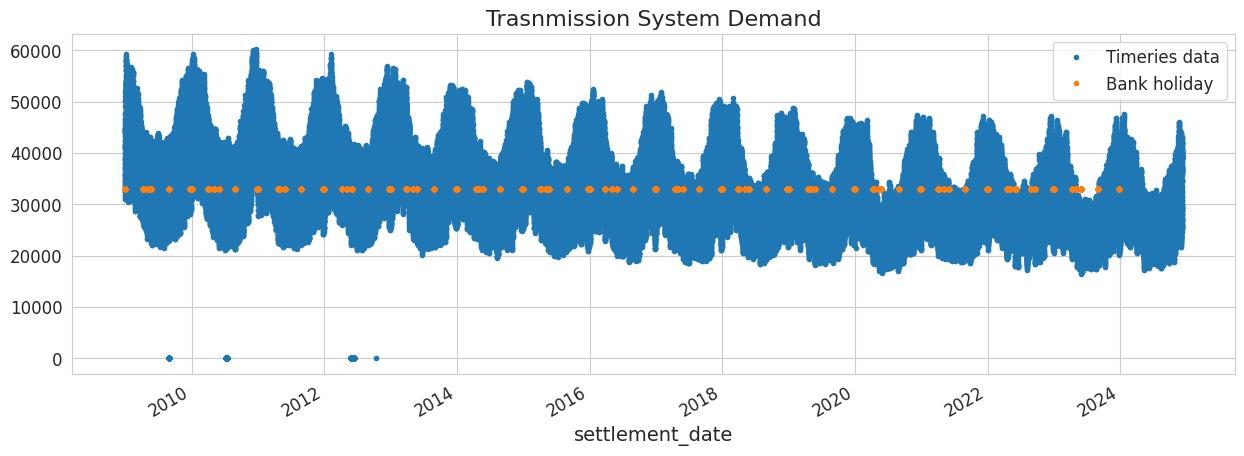

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

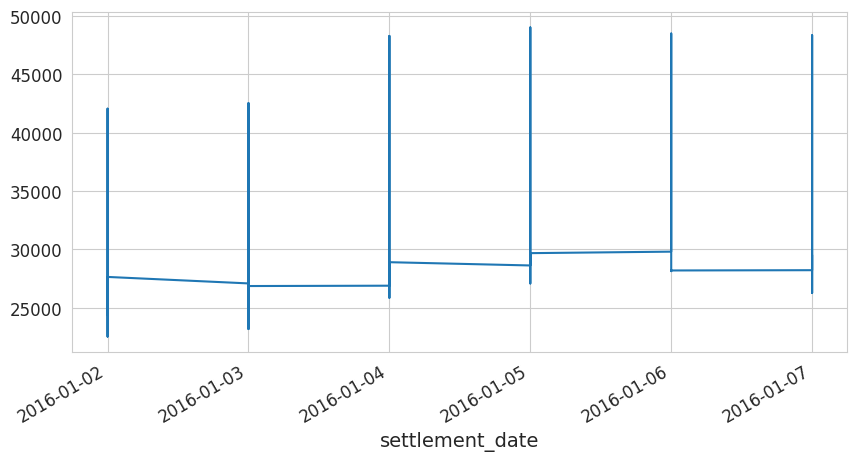

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [ ]:
df_plot.head()


settlement_period     nd    tsd  england_wales_demand  \
settlement_date                                                          
2009-01-01                       1  37910  38704                 33939   
2009-01-01                       2  38047  38964                 34072   
2009-01-01                       3  37380  38651                 33615   
2009-01-01                       4  36426  37775                 32526   
2009-01-01                       5  35687  37298                 31877   

                 embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                     
2009-01-01                             54                    1403   
2009-01-01                             53                    1403   
2009-01-01                             53                    1403   
2009-01-01                             50                    1403   
2009-01-01                             50                    1403   

                 embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                       
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   

                 non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  \
settlement_date                                                           
2009-01-01                 0                    33      2002          0   
2009-01-01                 0                   157      2002          0   
2009-01-01                 0                   511      2002          0   
2009-01-01                 0                   589      1772          0   
2009-01-01                 0                   851      1753          0   

                 britned_flow  moyle_flow  east_west_flow  nemo_flow  \
settlement_date                                                        
2009-01-01                  0        -161               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   

                 scottish_transfer  viking_flow  greenlink_flow  is_holiday  
settlement_date                                                              
2009-01-01                     NaN          NaN             NaN           1  
2009-01-01                     NaN          NaN             NaN           1  
2009-01-01                     NaN          NaN             NaN           1  
2009-01-01                     NaN          NaN             NaN           1  
2009-01-01                     NaN          NaN             NaN           1

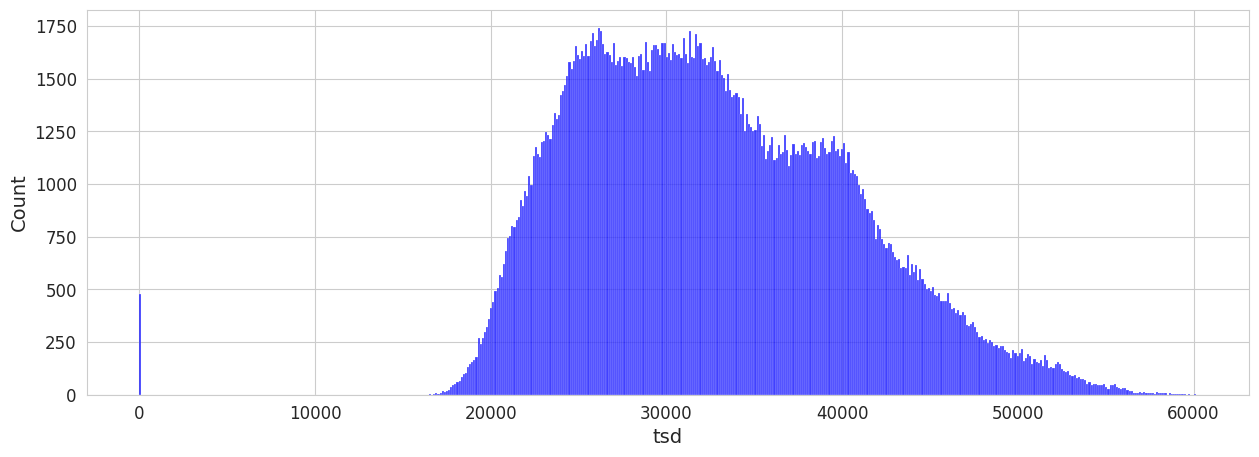

In [ ]:
ig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

settlement_date  settlement_period period_hour     nd    tsd  \
103090      2014-12-03                 47    23:00:00  33342  34232   
255796      2023-08-20                 35    17:00:00  21844  23254   
174149      2018-12-23                 26    12:30:00  35425  36926   
225194      2021-11-21                  5     2:00:00  21491  24475   
248297      2023-03-17                 22    10:30:00  31664  32293   
141706      2017-02-15                 27    13:00:00  41175  41993   
39847       2011-04-17                 14     6:30:00  24126  25983   

        england_wales_demand  embedded_wind_generation  \
103090                 30031                       515   
255796                 20019                      1871   
174149                 31807                       977   
225194                 20193                      2332   
248297                 28720                      1531   
141706                 37427                      1242   
39847                  21628                       128   

        embedded_wind_capacity  embedded_solar_generation  \
103090                    4039                          0   
255796                    6538                       3601   
174149                    5918                        469   
225194                    6527                          0   
248297                    6545                       3032   
141706                    4781                       1450   
39847                     1761                          1   

        embedded_solar_capacity  ...  ifa_flow  ifa2_flow  britned_flow  \
103090                     5911  ...      1994          0          1014   
255796                    15819  ...       455        357          -501   
174149                    13052  ...      1997          0          1000   
225194                    13080  ...      -510       -841          1048   
248297                    15278  ...      1502        992          1001   
141706                    11503  ...       496          0           971   
39847                       144  ...       924          0           293   

        moyle_flow  east_west_flow  nemo_flow  scottish_transfer  viking_flow  \
103090        -128            -111          0                NaN          NaN   
255796         384             251       -403             2470.0          0.0   
174149        -454            -436          0                NaN          NaN   
225194         325               0        912                NaN          NaN   
248297         -24               0        940              336.0          0.0   
141706        -151             -62          0                NaN          NaN   
39847         -104               0          0                NaN          NaN   

        greenlink_flow  is_holiday  
103090             NaN           0  
255796             NaN           0  
174149             NaN           0  
225194             NaN           0  
248297             NaN           0  
141706             NaN           0  
39847              NaN           0  

[7 rows x 22 columns]

In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

settlement_date  settlement_period period_hour     nd    tsd  \
175086 2019-01-12 01:00:00                  3     1:00:00  25752  26408   
105408 2015-01-21 06:00:00                 13     6:00:00  35519  36216   
110894 2015-05-15 14:00:00                 29    14:00:00  32125  33178   
92127  2014-04-19 13:30:00                 28    13:30:00  29570  30776   
247236 2023-02-23 08:00:00                 17     8:00:00  34143  35703   

        england_wales_demand  embedded_wind_generation  \
175086                 24321                      2608   
105408                 32078                       857   
110894                 29249                      1118   
92127                  26768                       655   
247236                 30959                      1659   

        embedded_wind_capacity  embedded_solar_generation  \
175086                    5918                          0   
105408                    4067                          0   
110894                    3789                       4580   
92127                     2524                       2550   
247236                    6545                        675   

        embedded_solar_capacity  ...  ifa_flow  ifa2_flow  britned_flow  \
175086                    13052  ...      1419          0           744   
105408                     6102  ...       399          0           778   
110894                     8576  ...      1997          0           992   
92127                      4603  ...      1998          0           998   
247236                    15206  ...       707        398           128   

        moyle_flow  east_west_flow  nemo_flow  scottish_transfer  viking_flow  \
175086          67             437          0                NaN          NaN   
105408         101             166          0                NaN          NaN   
110894        -148            -404          0                NaN          NaN   
92127         -247            -449          0                NaN          NaN   
247236        -444            -504        473              912.0          0.0   

        greenlink_flow  is_holiday  
175086             NaN           0  
105408             NaN           0  
110894             NaN           0  
92127              NaN           0  
247236             NaN           0  

[5 rows x 22 columns]

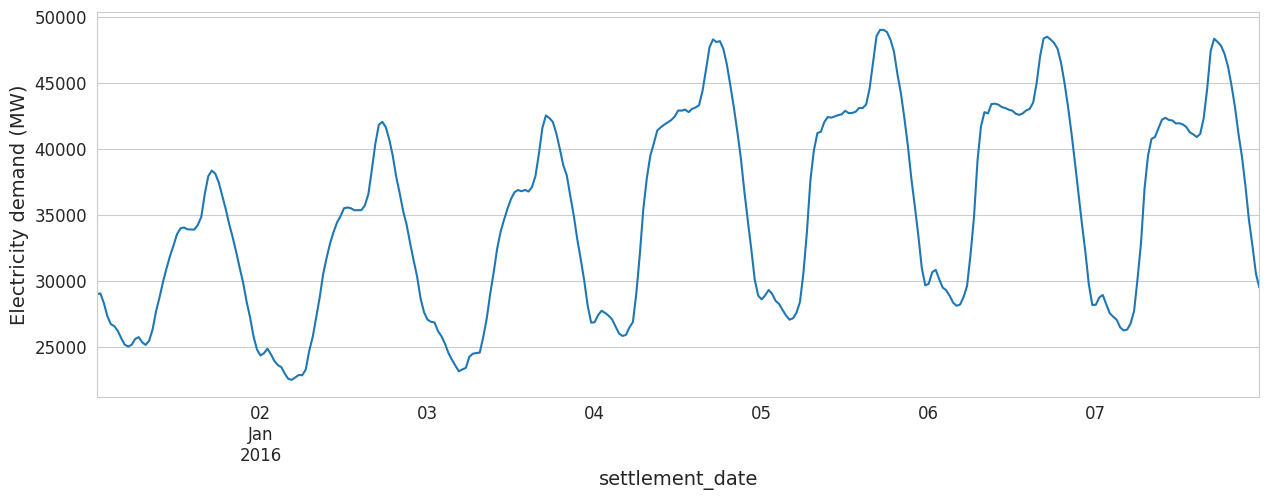

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2021-01-24 11:00:00                 23    11:00:00  36903  37514   
2018-02-17 00:30:00                  2     0:30:00  28394  29586   
2022-11-17 06:30:00                 14     6:30:00  26461  30788   
2011-11-08 21:30:00                 44    21:30:00  38799  39638   
2009-03-01 03:30:00                  8     3:30:00  28442  30993   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2021-01-24 11:00:00                 33511                       577   
2018-02-17 00:30:00                 26633                      1941   
2022-11-17 06:30:00                 24529                      2299   
2011-11-08 21:30:00                 35281                       391   
2009-03-01 03:30:00                 25533                       413   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2021-01-24 11:00:00                    6527                       1480   
2018-02-17 00:30:00                    5779                          0   
2022-11-17 06:30:00                    6545                          0   
2011-11-08 21:30:00                    1845                          0   
2009-03-01 03:30:00                    1419                          0   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_month  \
settlement_date                                            ...                 
2021-01-24 11:00:00                    13080            0  ...            24   
2018-02-17 00:30:00                    12916            0  ...            17   
2022-11-17 06:30:00                    13861            0  ...            17   
2011-11-08 21:30:00                      952            0  ...             8   
2009-03-01 03:30:00                        0            0  ...             1   

                     day_of_week  day_of_year  quarter  month  year  \
settlement_date                                                       
2021-01-24 11:00:00            6           24        1      1  2021   
2018-02-17 00:30:00            5           48        1      2  2018   
2022-11-17 06:30:00            3          321        4     11  2022   
2011-11-08 21:30:00            1          312        4     11  2011   
2009-03-01 03:30:00            6           60        1      3  2009   

                     week_of_year     lag1     lag2     lag3  
settlement_date                                               
2021-01-24 11:00:00             3  33789.0  31765.0  32579.0  
2018-02-17 00:30:00             7  29120.0  28447.0  32851.0  
2022-11-17 06:30:00            46  29308.0  27874.0  34703.0  
2011-11-08 21:30:00            45  41804.0  44067.0      NaN  
2009-03-01 03:30:00             9      NaN      NaN      NaN  

[5 rows x 31 columns]

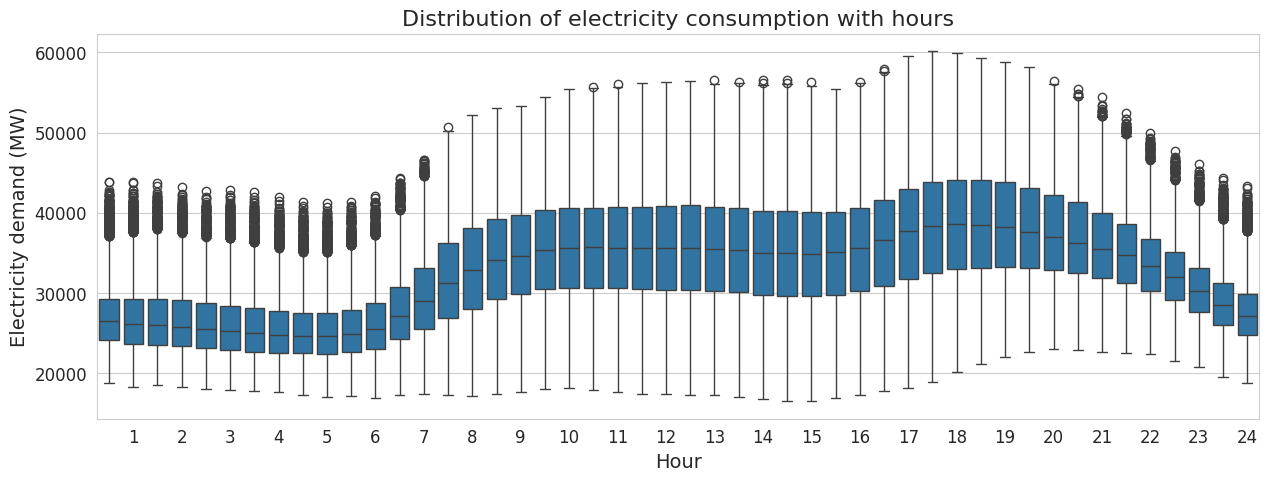

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

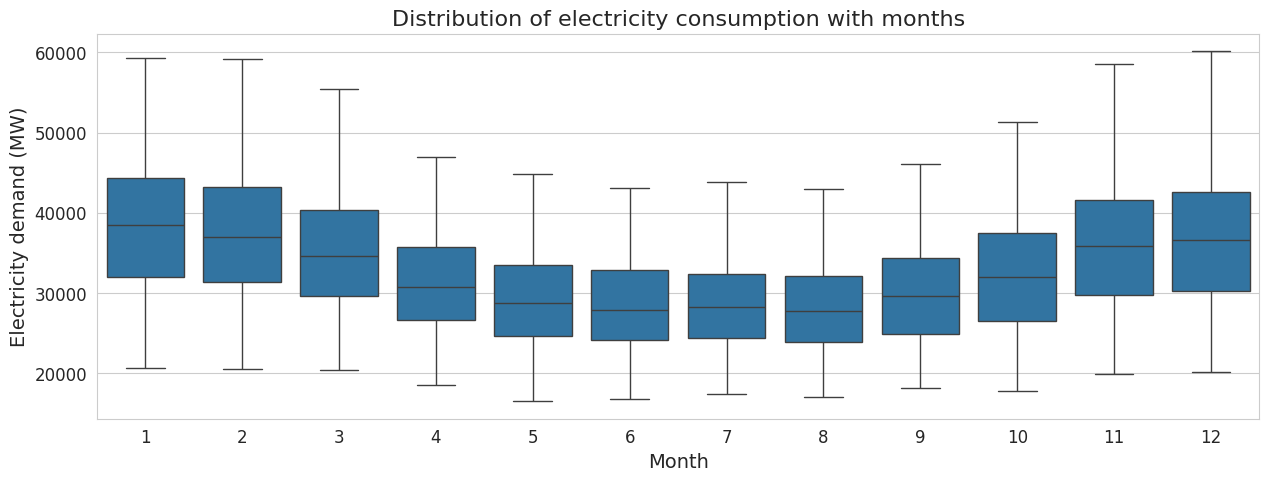

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

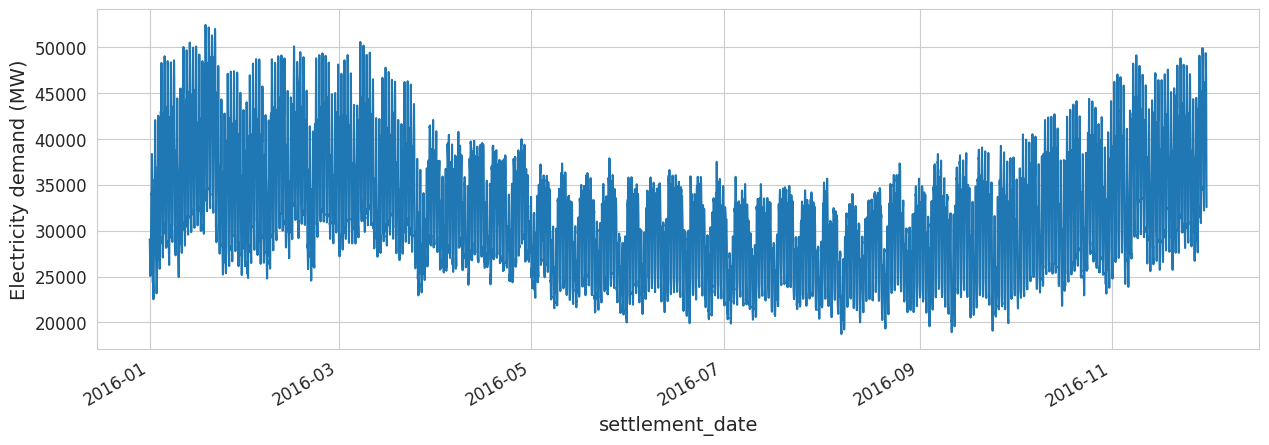

In [ ]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

<ipython-input-30-a43933627e79>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


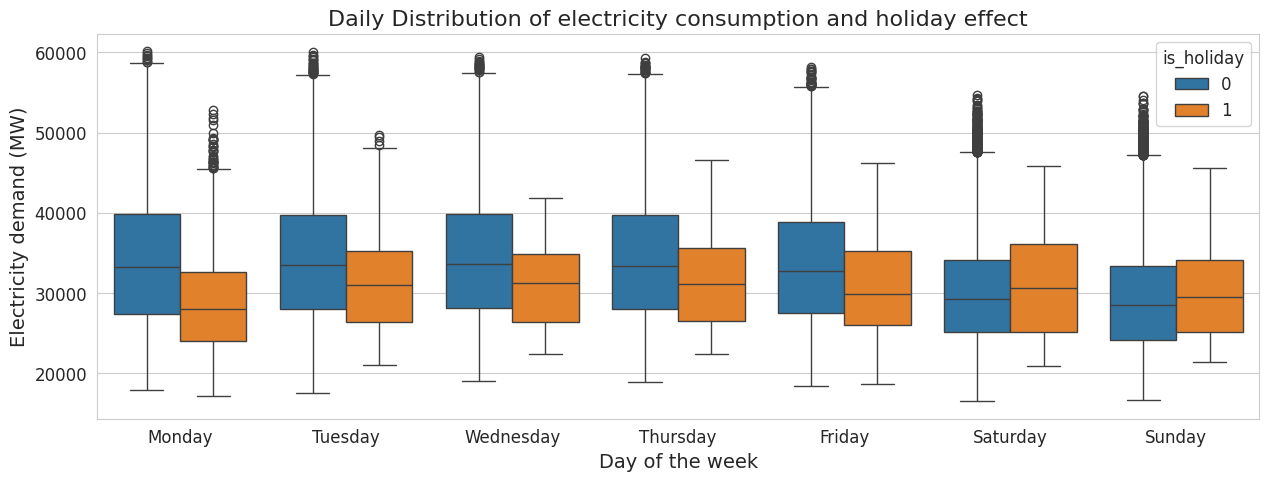

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

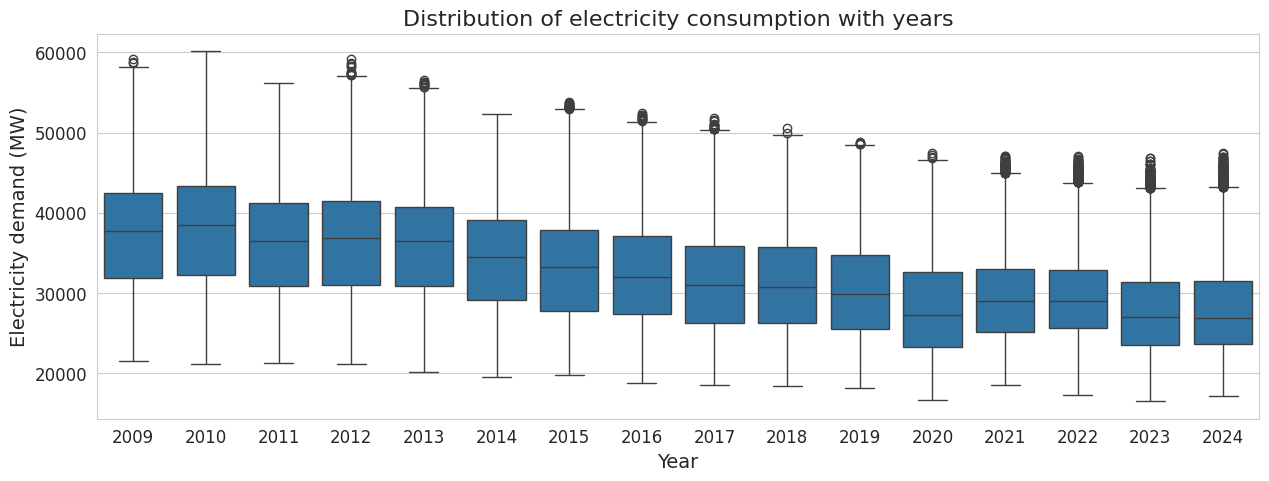

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

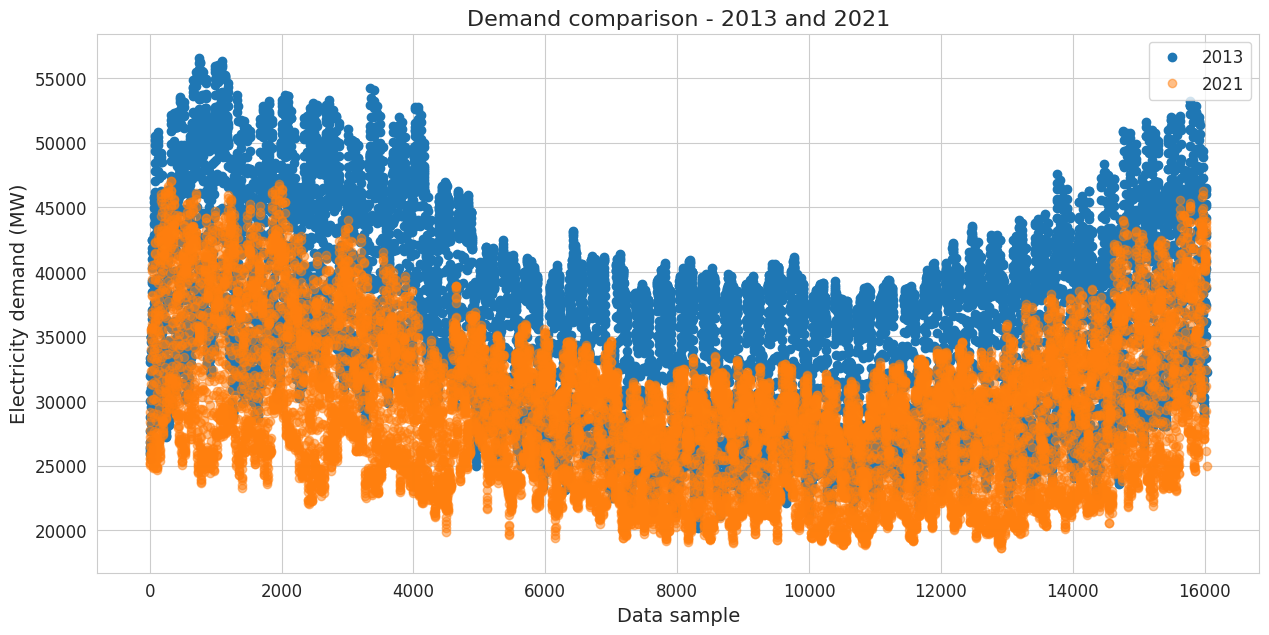

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

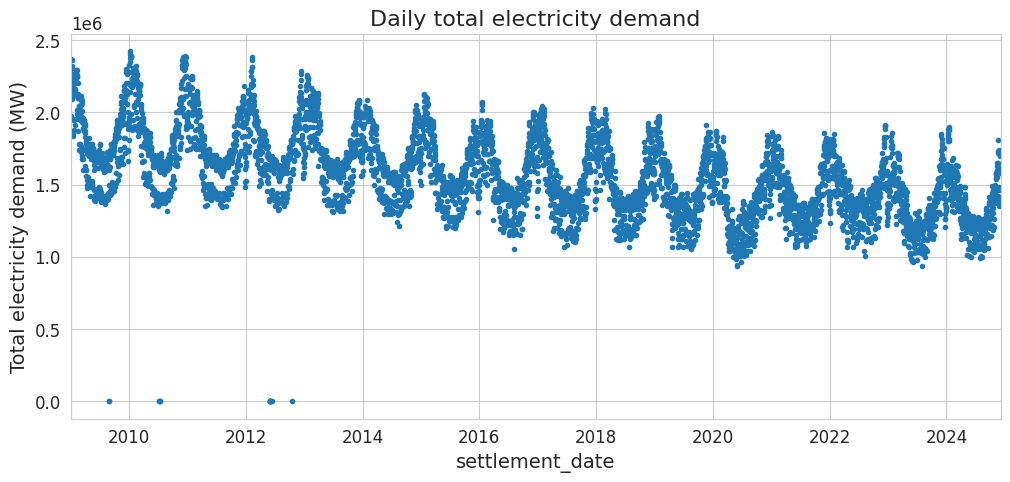

In [ ]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

<ipython-input-35-61431c4f6e5f>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1487356.8387096773, 1487356.8387096773, 1370343.8709677418, 1370343.8709677418, 1370343.8709677418, 1370343.8709677418, 1504213.3548387096, 1504213.3548387096, 1504213.3548387096, 1311741.7, 1311741.7, 1311741.7, 1311741.7, 1311741.7, 1690462.0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sarima.loc[null_days, "tsd"] = mean_values


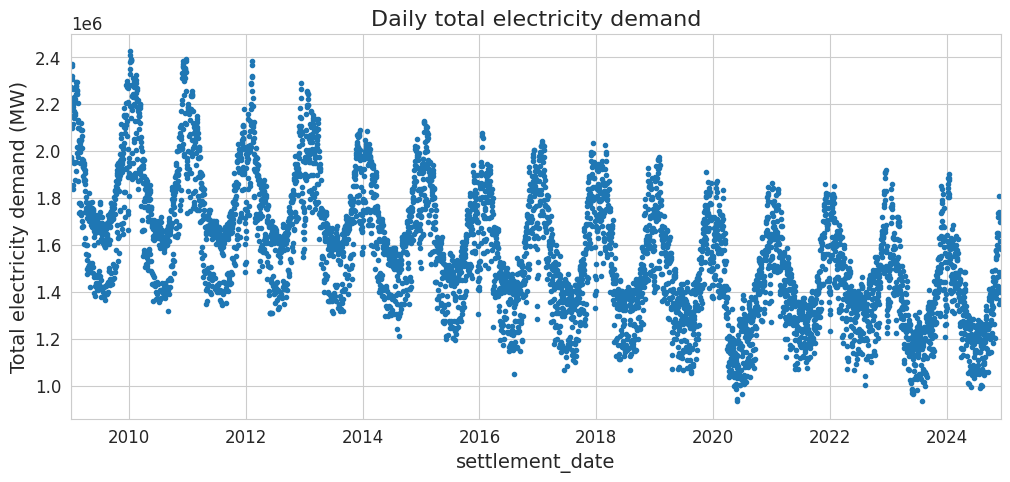

In [ ]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [ ]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

In [ ]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

Test Statistic            -3.652464
p-value                    0.004834
Lags Used                 34.000000
Observations Used       5783.000000
Critical Value (1%)       -3.431481
Critical Value (5%)       -2.862040
Critical Value (10%)      -2.567036
dtype: float64


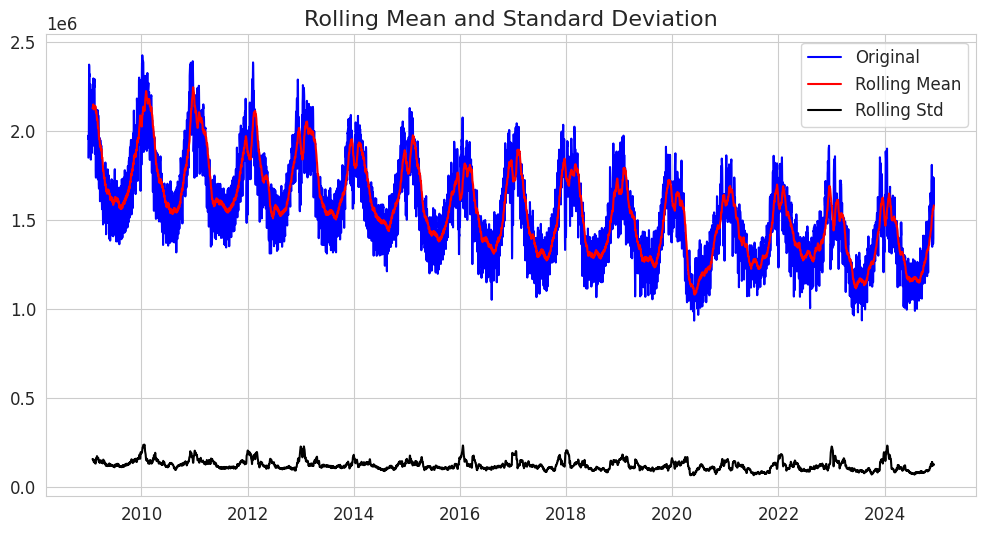

In [ ]:
dftest(df_sarima["tsd"], 30)

Test Statistic         -1.539974e+01
p-value                 3.227051e-28
Lags Used               3.400000e+01
Observations Used       5.782000e+03
Critical Value (1%)    -3.431481e+00
Critical Value (5%)    -2.862040e+00
Critical Value (10%)   -2.567036e+00
dtype: float64


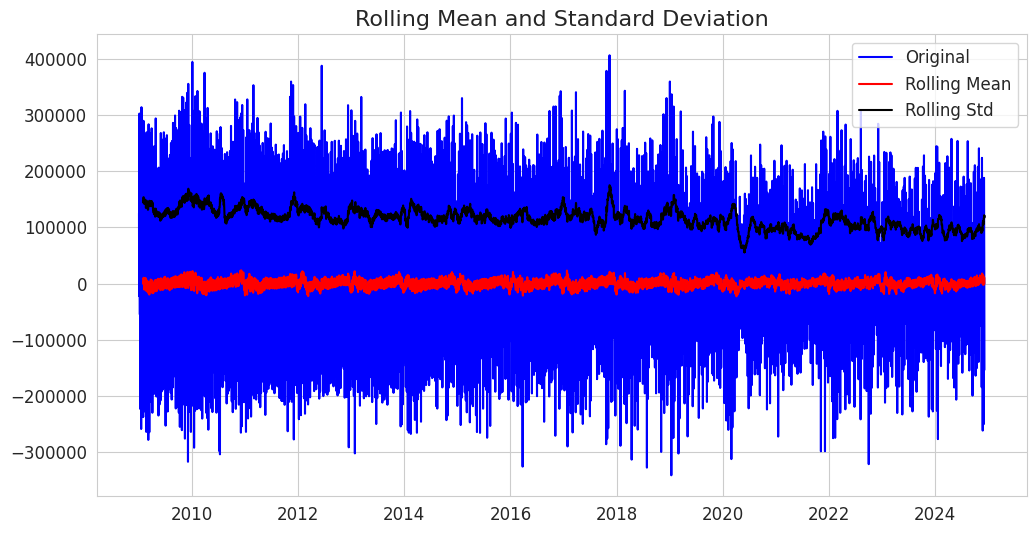

In [ ]:
dftest(df_sarima["difference_day"].dropna(), 30)

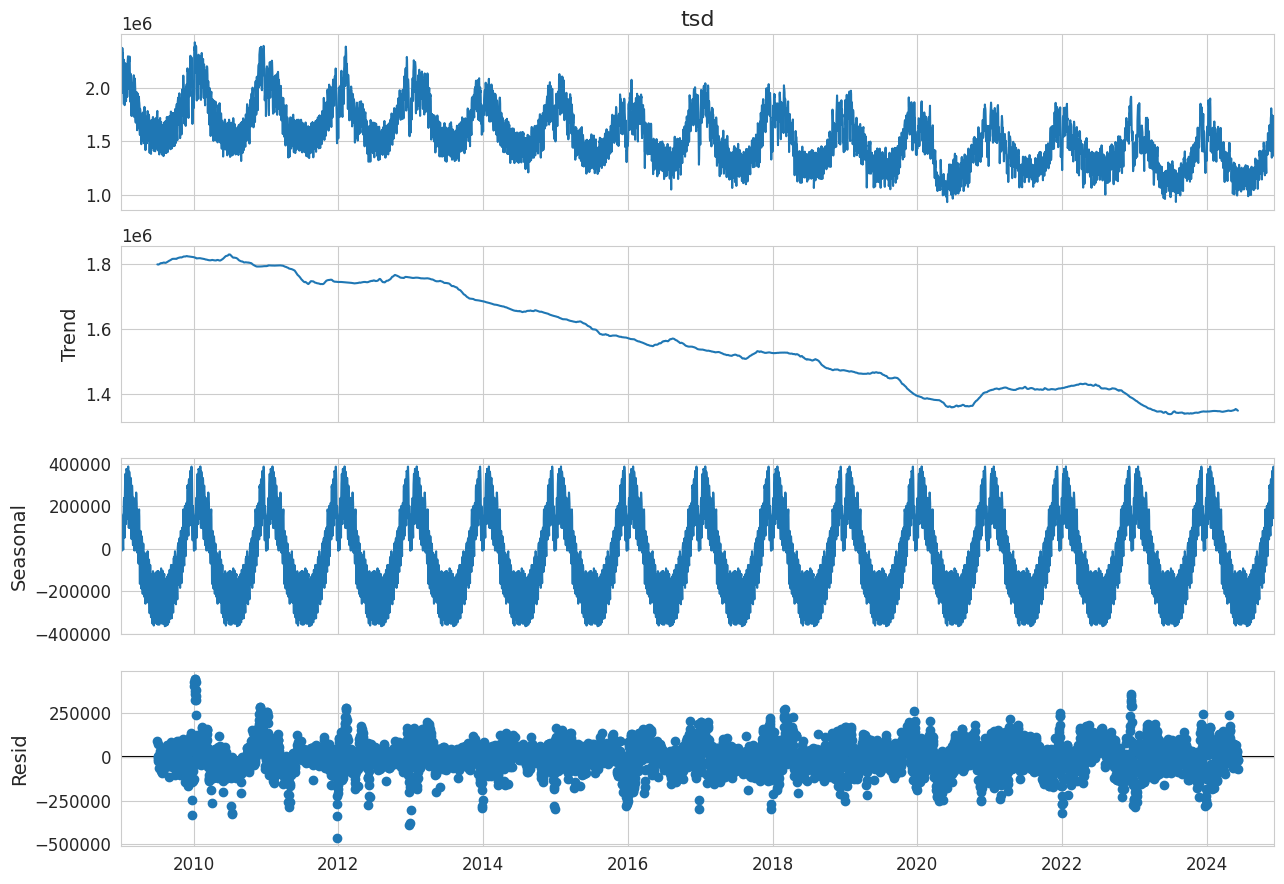

In [ ]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Test Statistic            -4.876749
p-value                    0.000039
Lags Used                 34.000000
Observations Used       5783.000000
Critical Value (1%)       -3.431481
Critical Value (5%)       -2.862040
Critical Value (10%)      -2.567036
dtype: float64


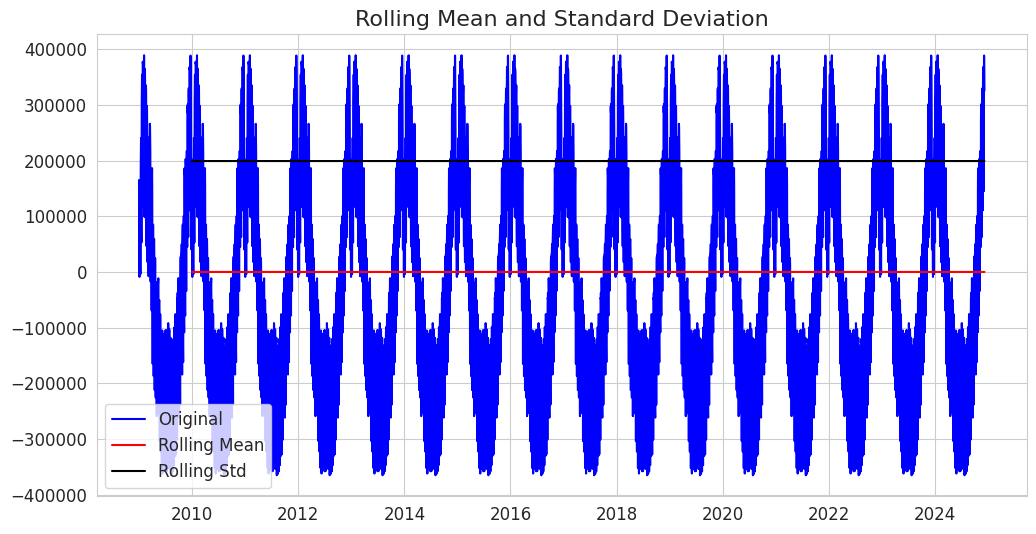

In [ ]:
dftest(decompose.seasonal, 364)

Test Statistic         -8.268587e+00
p-value                 4.862131e-13
Lags Used               2.600000e+01
Observations Used       5.427000e+03
Critical Value (1%)    -3.431556e+00
Critical Value (5%)    -2.862073e+00
Critical Value (10%)   -2.567054e+00
dtype: float64


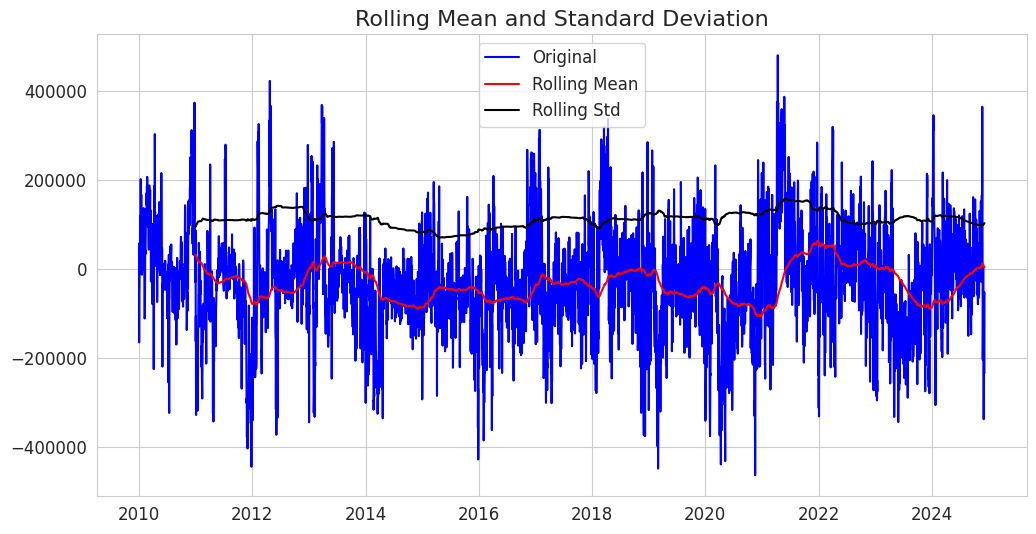

In [ ]:
dftest(df_sarima["difference_year"].dropna(), 364)

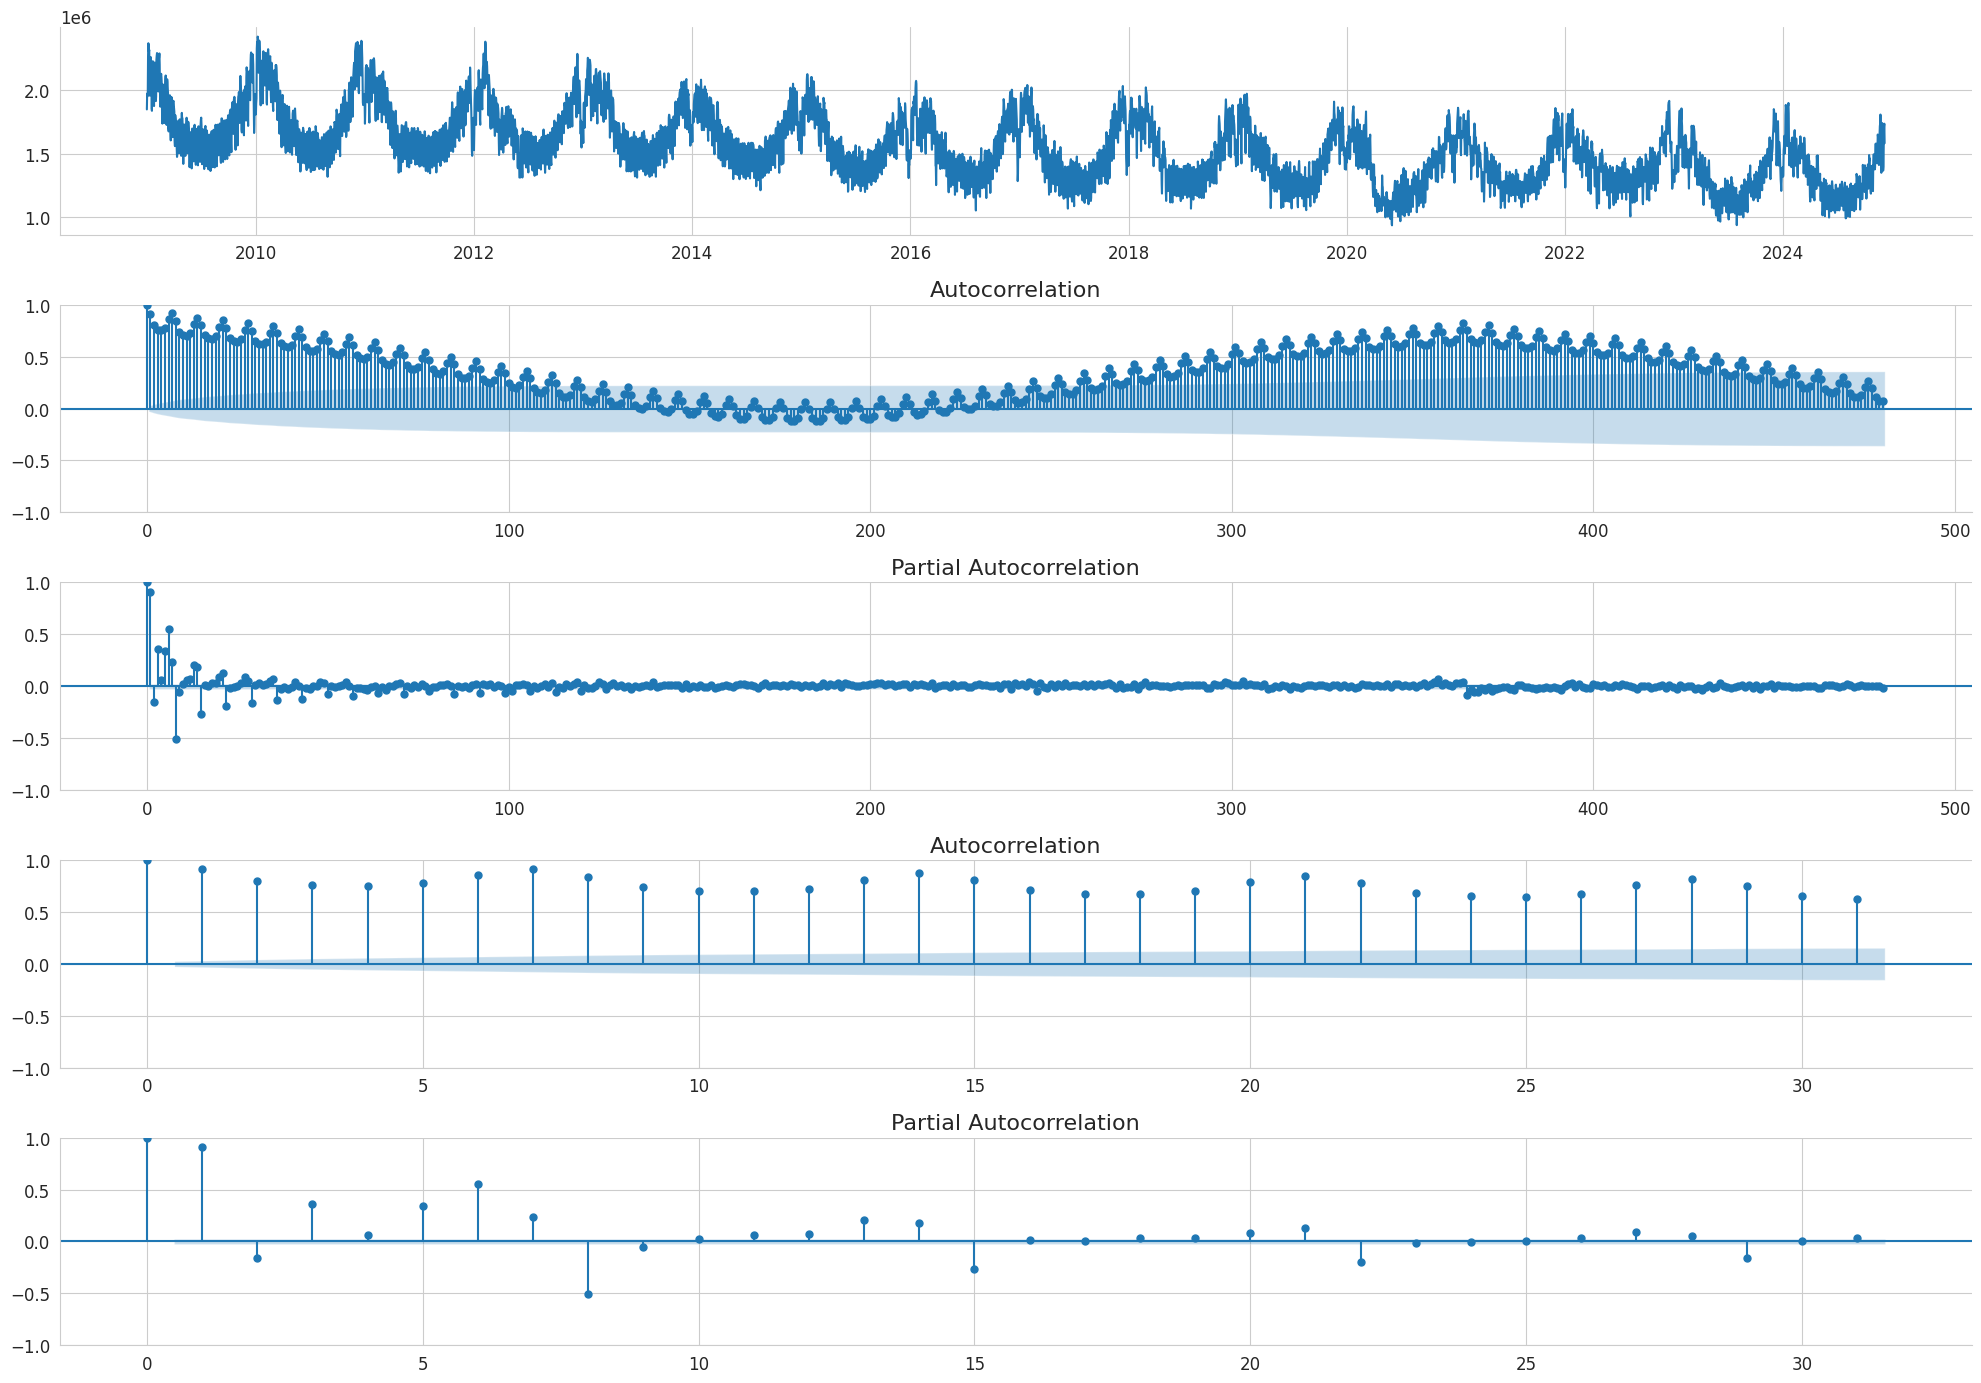

In [ ]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

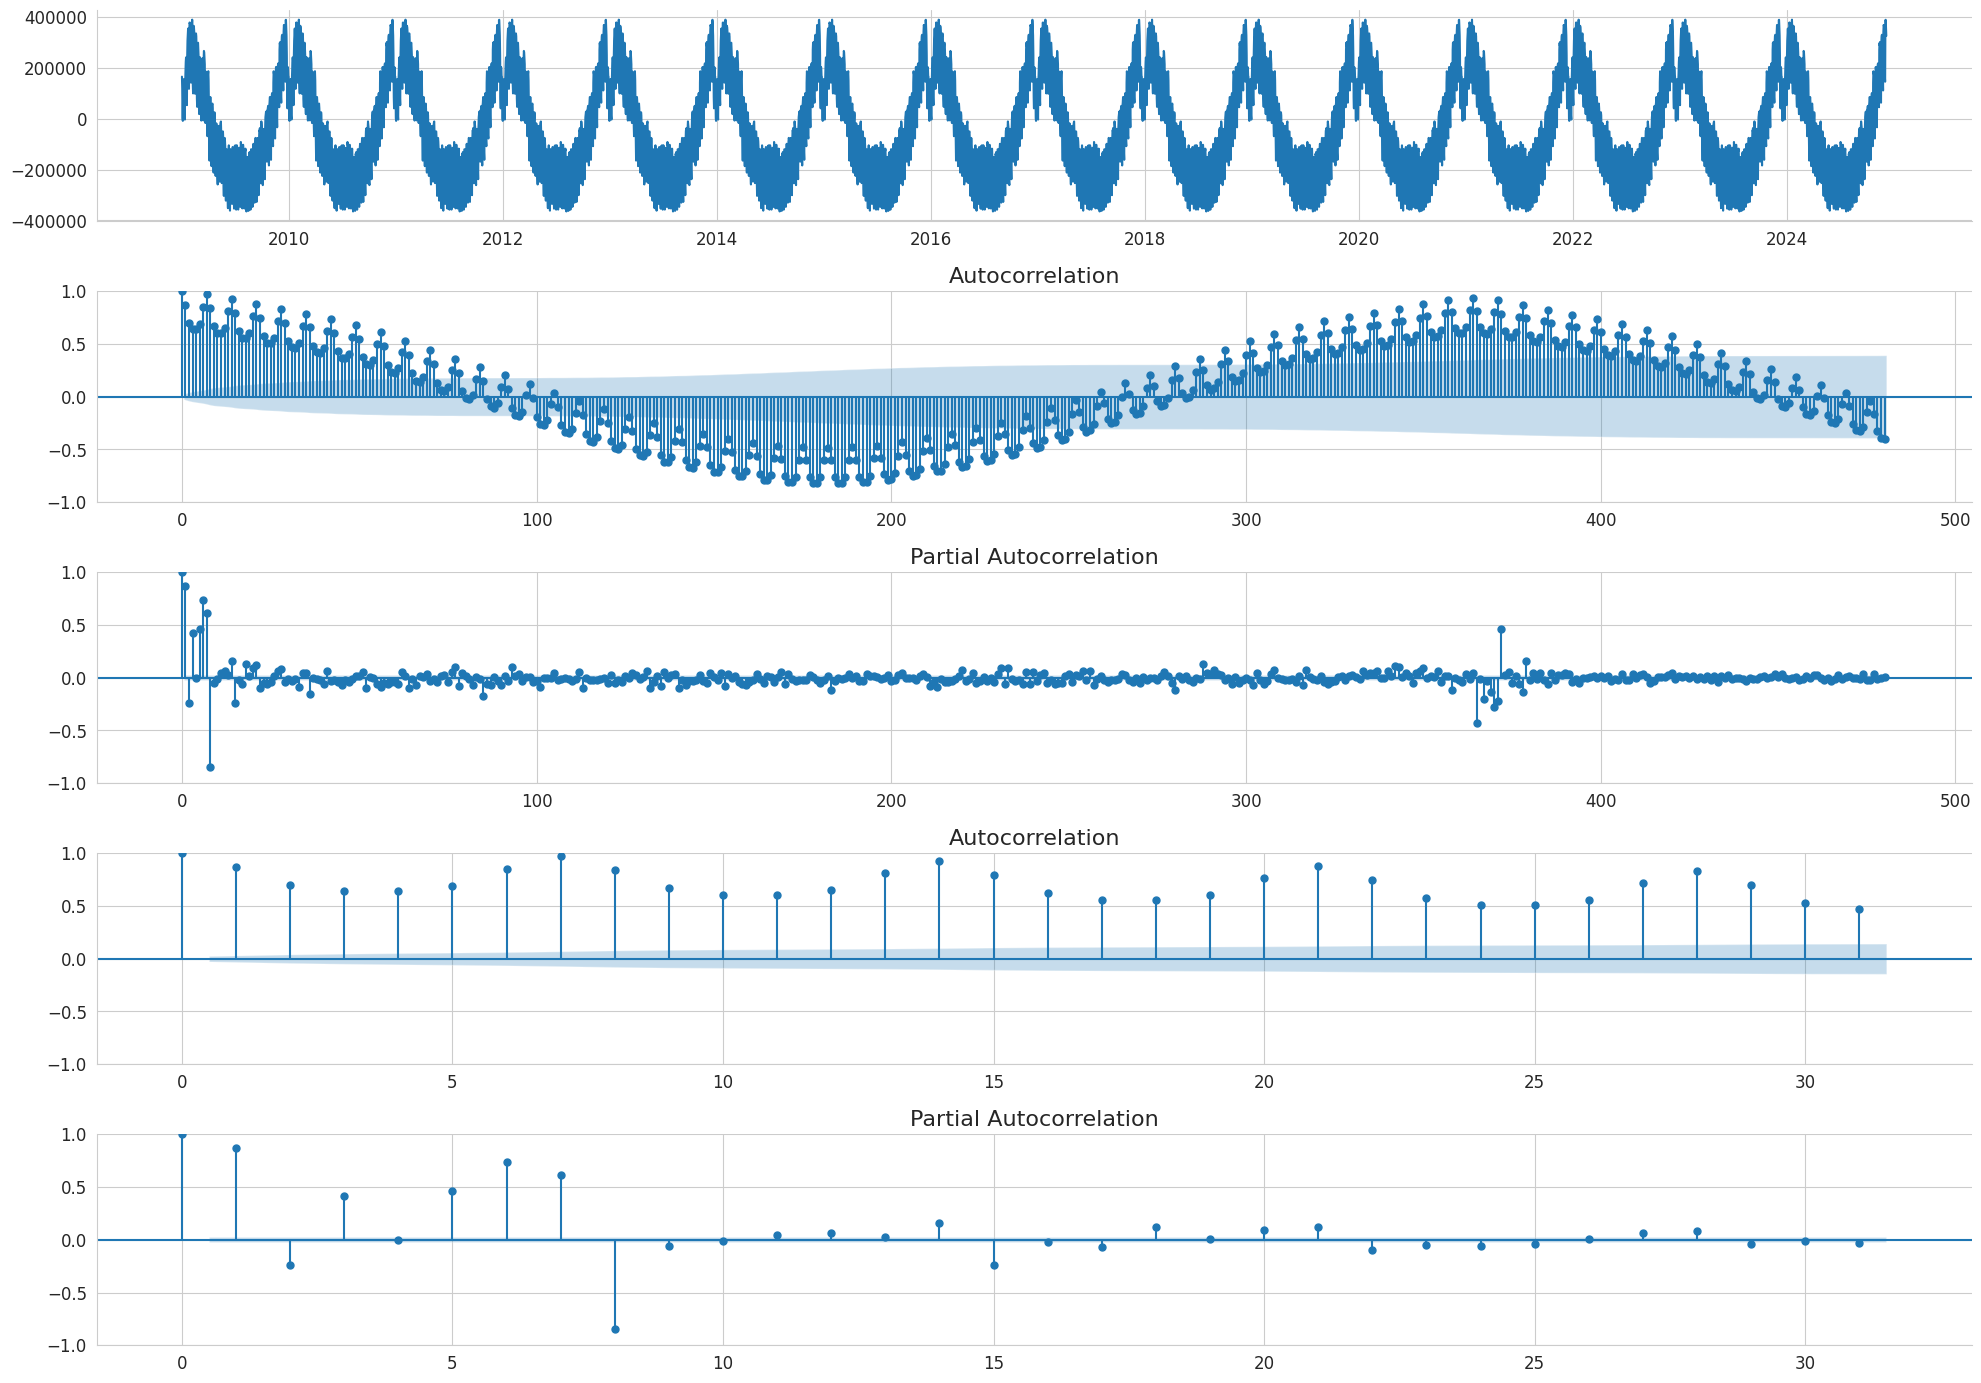

In [ ]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

In [ ]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

In [ ]:

def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model


BASE MODEL OF SARIMA

Normality: val=1086.819, p=0.000
Ljung-Box: val=7216.653, p=0.000
Heteroskedasticity: val=0.865, p=0.006
Durbin-Watson: d=2.03
-------------------------------------------------------------


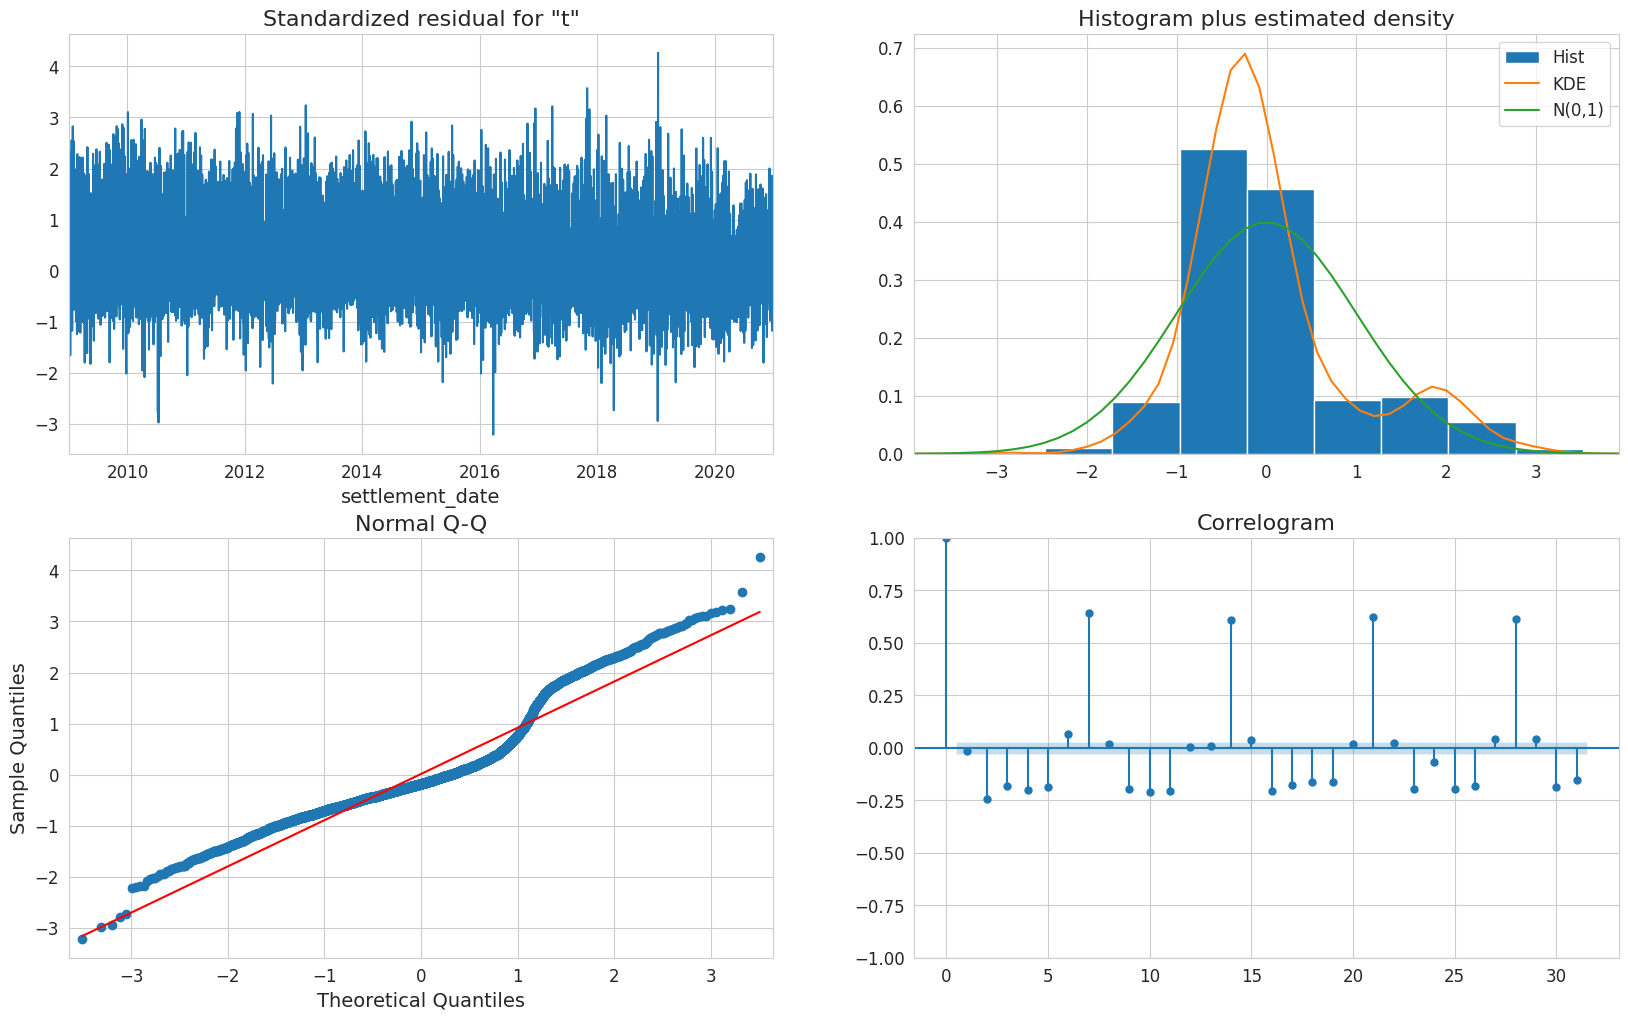

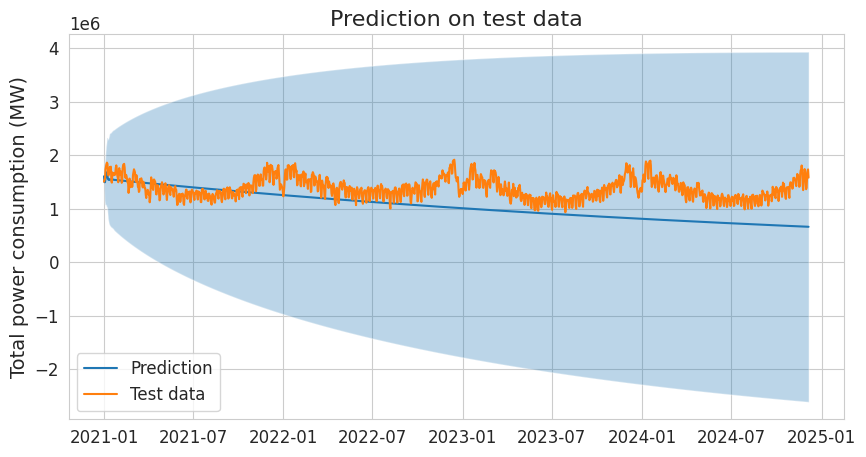

In [ ]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

Model 0 MAPE value: 26.093724807129288
Model 0 runtime: 0:00:19.239522


MODEL - 1

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=1754.684, p=0.000
Ljung-Box: val=513.530, p=0.000
Heteroskedasticity: val=0.964, p=0.486
Durbin-Watson: d=2.04
-------------------------------------------------------------


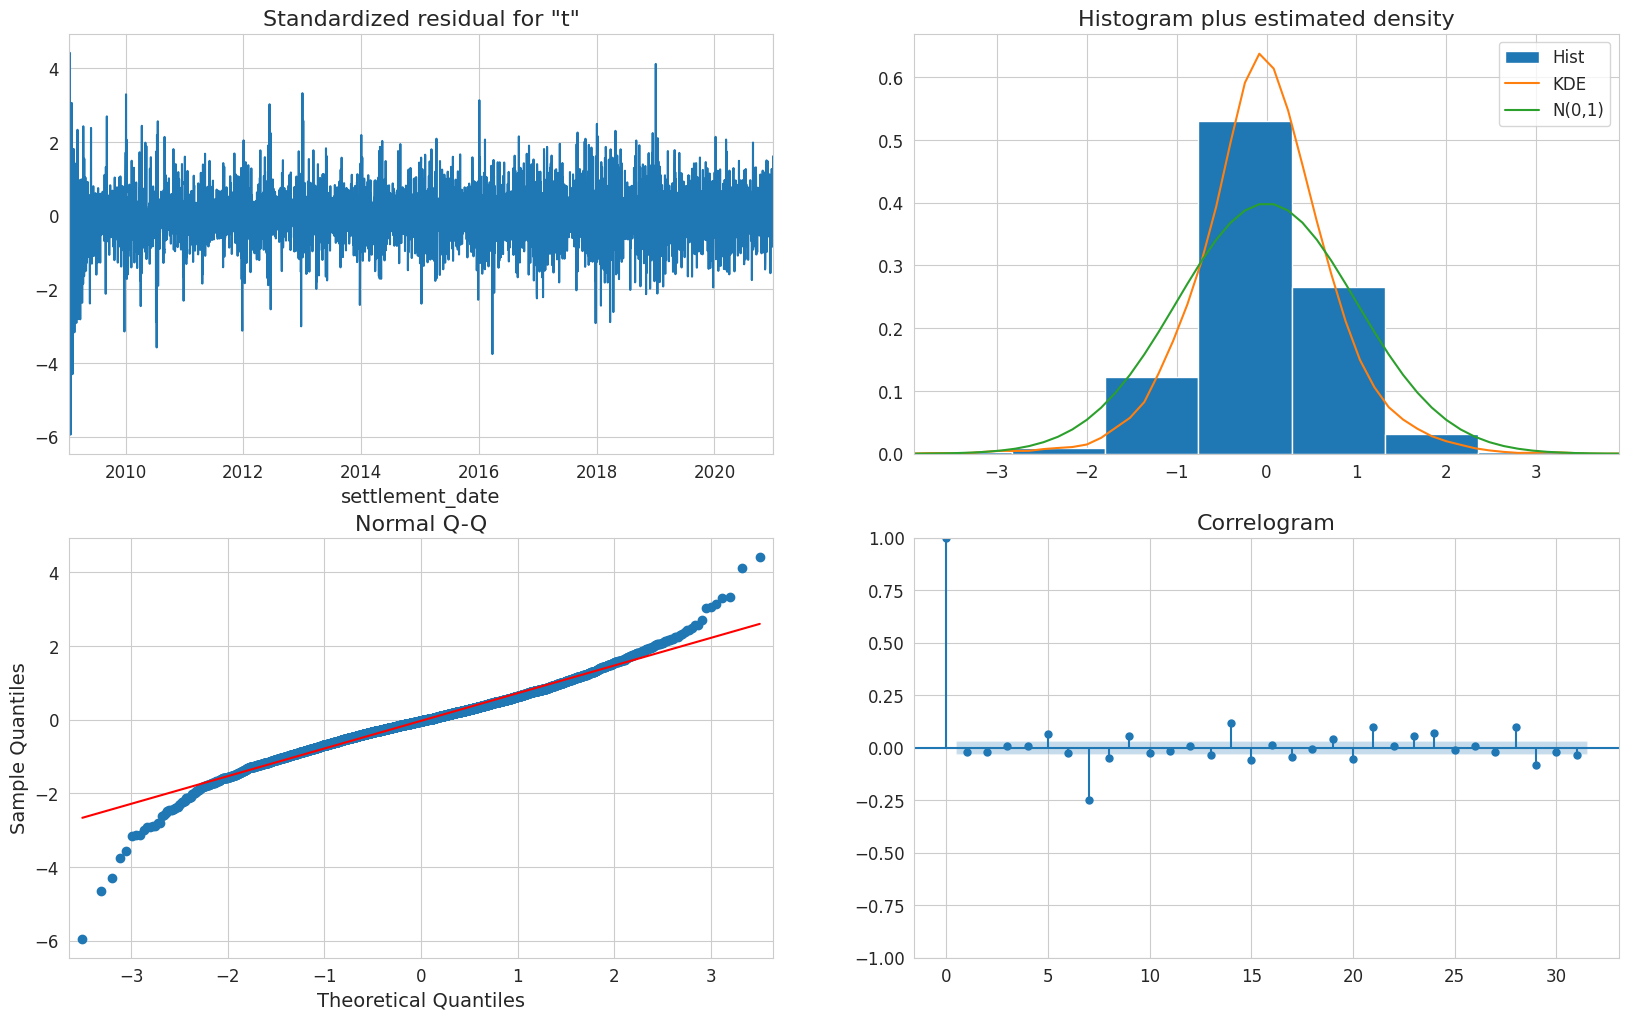

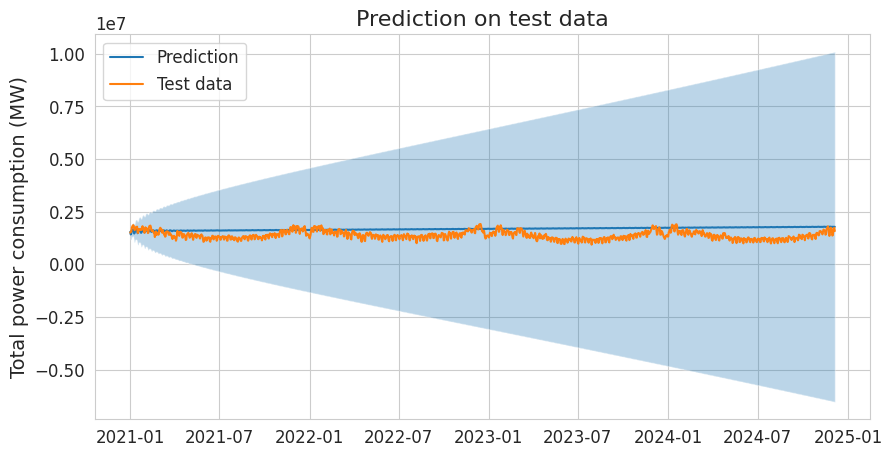

In [ ]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (7, 1, 2), (3, 1, 2, 12), 50, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_1}")
print(f"Model 0 runtime: {execution_time_1}")

Model 0 MAPE value: 25.417808555790533
Model 0 runtime: 0:05:25.775944


MODEL - 2

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=929.381, p=0.000
Ljung-Box: val=891.159, p=0.000
Heteroskedasticity: val=1.012, p=0.819
Durbin-Watson: d=2.28
-------------------------------------------------------------


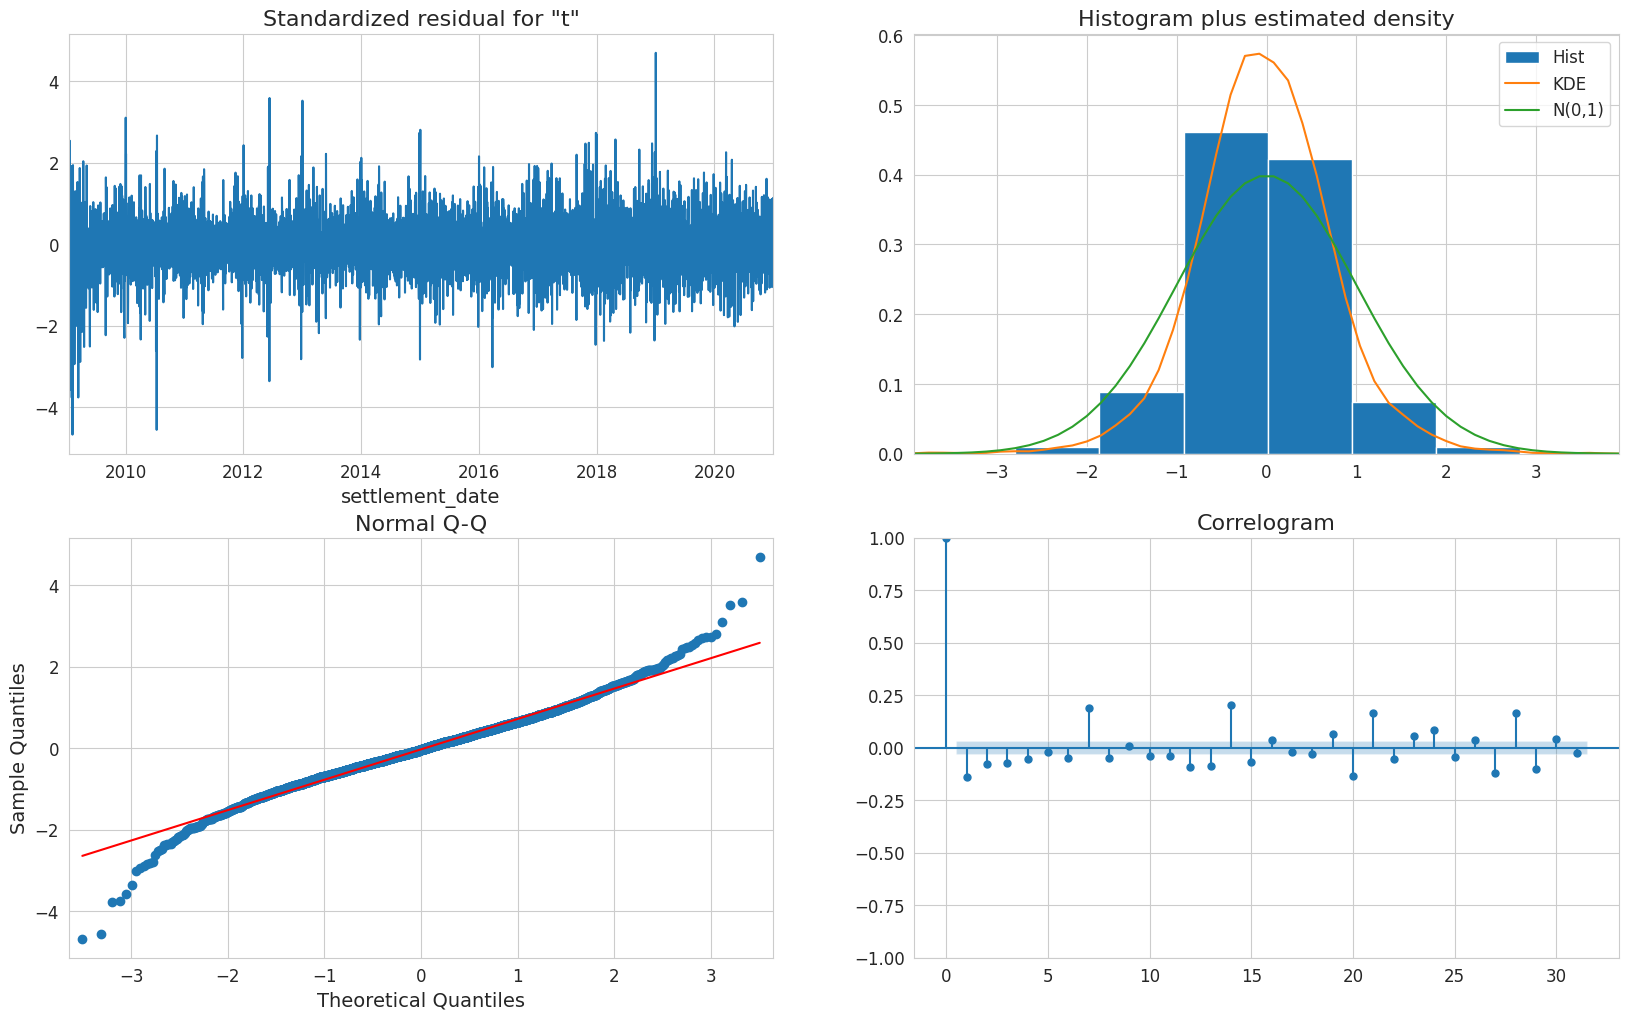

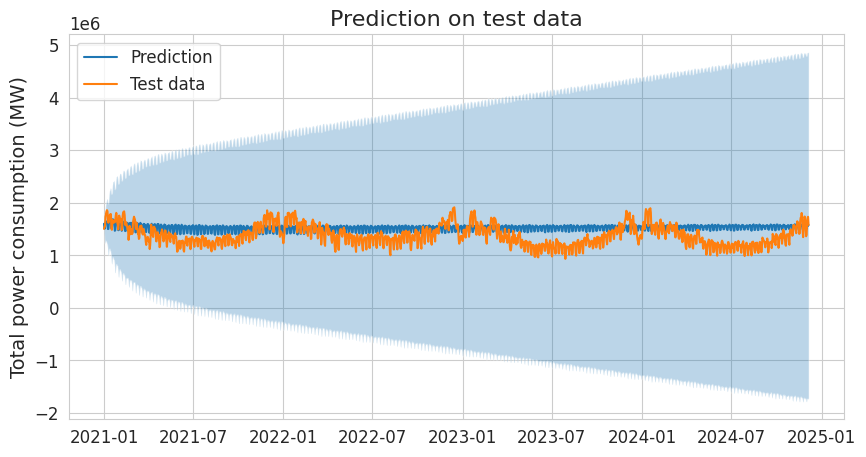

In [ ]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)


In [ ]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

Model 0 MAPE value: 15.330761813884983
Model 0 runtime: 0:07:02.790845


XGBOOST

In [ ]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

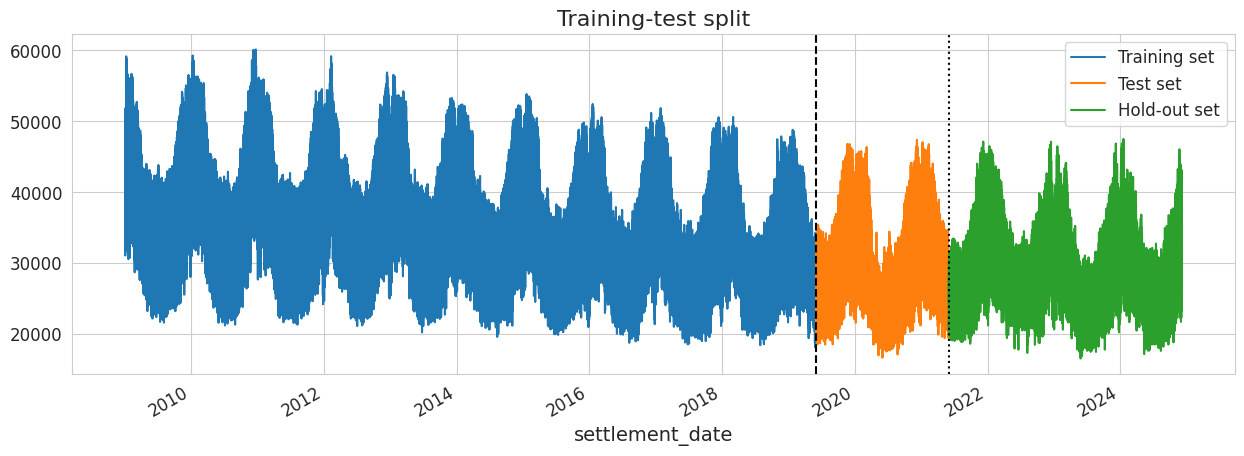

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8346.85689
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6453.99074
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5413.53964
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4781.77769
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4394.58408
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4151.85893


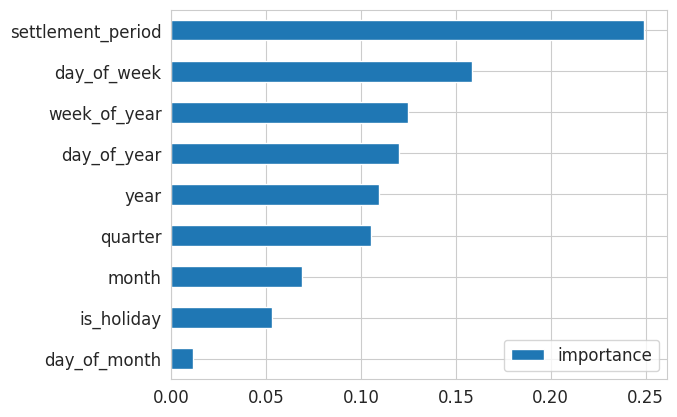

In [ ]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)


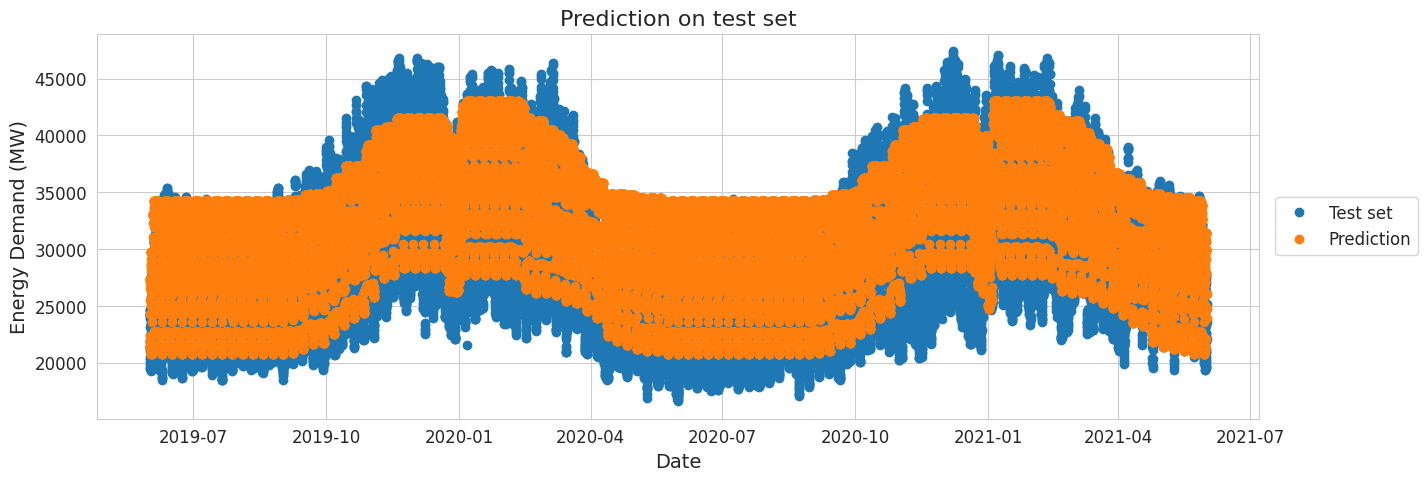

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

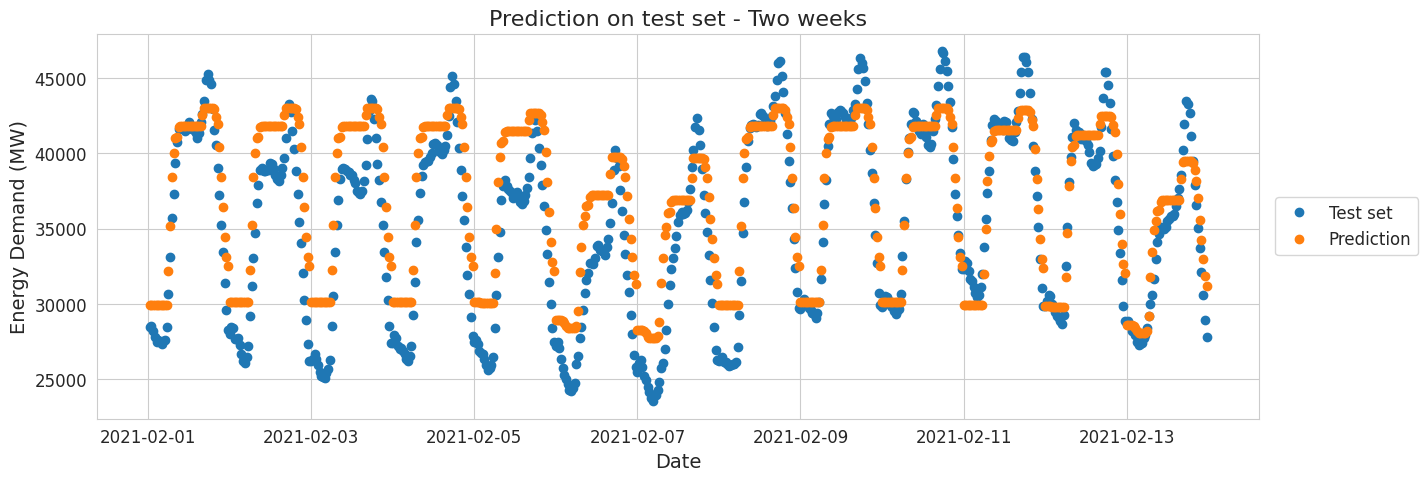

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


**XGBoost with Cross validation and Grid Search**

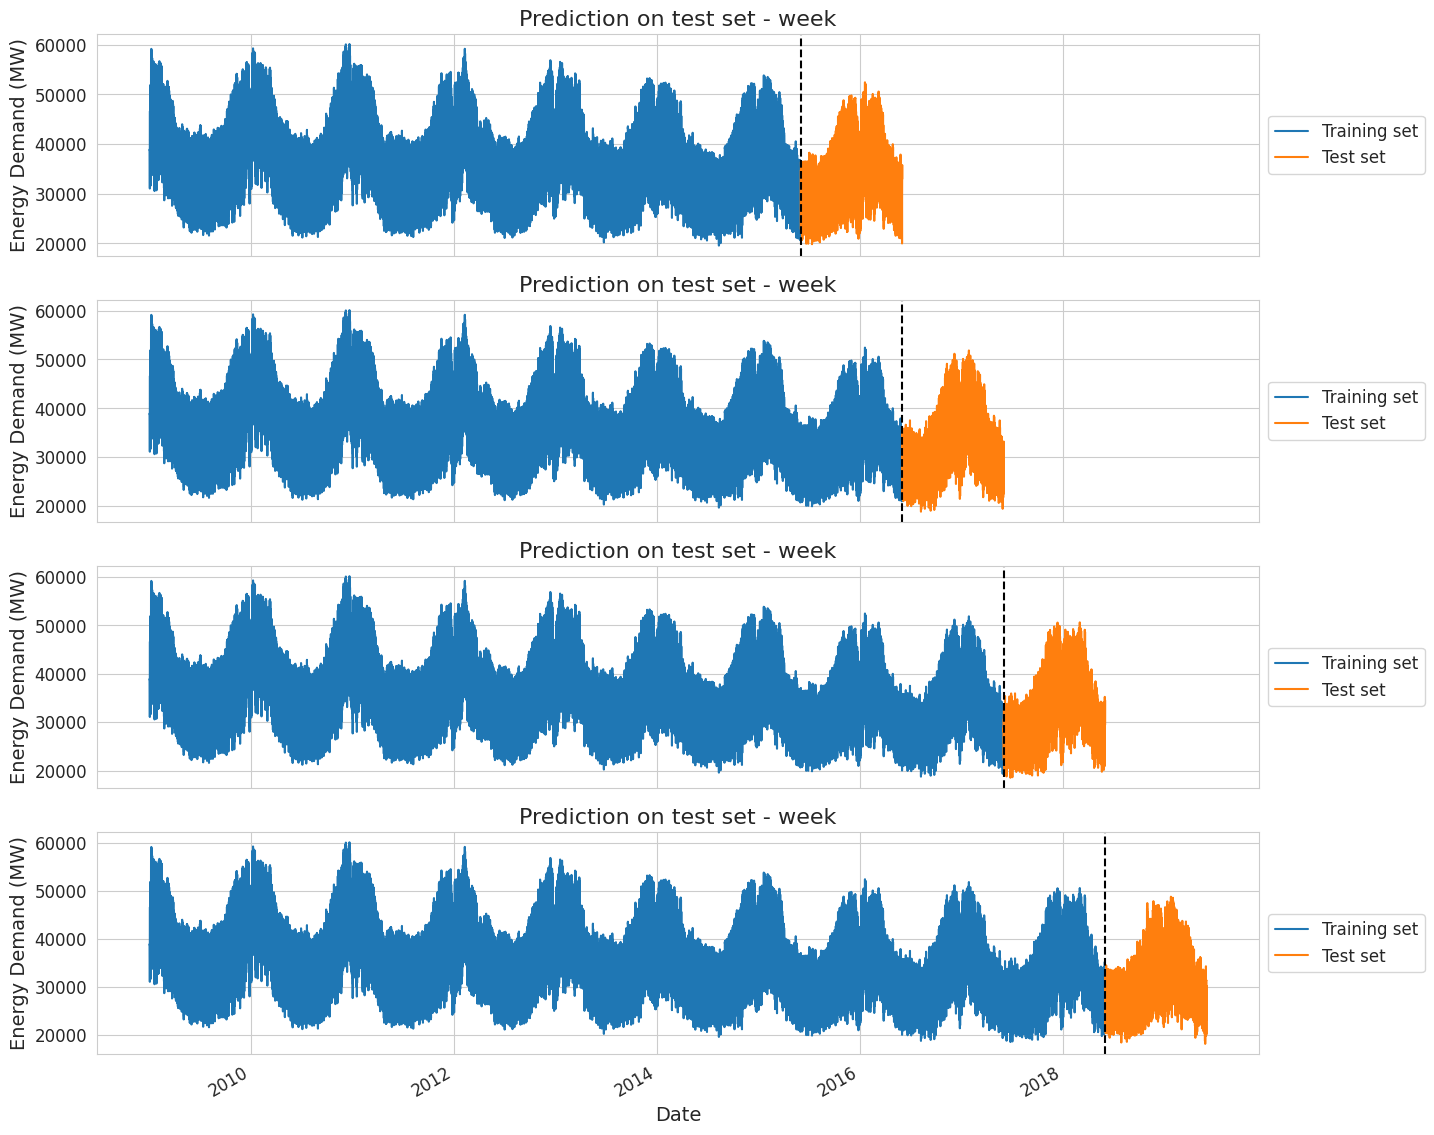

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np

# Ensure index is properly set
train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

# Define features and target
FEATURES_CV = [
    "settlement_period", "day_of_month", "day_of_week", "day_of_year",
    "quarter", "month", "year", "week_of_year", "lag1", "lag2", "lag3", "is_holiday"
]
TARGET = "tsd"

# Extract train and test sets
X_train_cv = train_data[FEATURES_CV].copy()
y_train_cv = train_data[TARGET].copy()

X_test_cv = test_data[FEATURES_CV].copy()
y_test_cv = test_data[TARGET].copy()

# Ensure hold-out set is available
if "hold_out_data" in locals():
    X_hold_out = hold_out_data[FEATURES_CV].copy()
    y_hold_out = hold_out_data[TARGET].copy()
    eval_set = [(X_hold_out, y_hold_out)]
else:
    eval_set = [(X_test_cv, y_test_cv)]  # Use test set as fallback

# Handle missing values (replace NaNs)
X_train_cv.fillna(0, inplace=True)
y_train_cv.fillna(0, inplace=True)
X_test_cv.fillna(0, inplace=True)
y_test_cv.fillna(0, inplace=True)

# Define Time Series Split (ensure enough data for splits)
n_splits = 4  # Set to 4 to match expected output
tss = TimeSeriesSplit(n_splits=n_splits)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    early_stopping_rounds=50,
    eval_metric="rmse"
)

# Define parameter grid
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}

# Perform Grid Search with Time Series Cross-Validation
xgb_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_search,
    cv=tss,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=-1
)

# Fit the model (without passing early_stopping_rounds in GridSearchCV)
xgb_search.fit(X_train_cv, y_train_cv, eval_set=eval_set, verbose=True)

# Print best parameters and score
print("Best Parameters:", xgb_search.best_params_)
print("Best RMSE Score:", -xgb_search.best_score_)


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:6364.01678
[1]	validation_0-rmse:5106.62650
[2]	validation_0-rmse:4104.69666
[3]	validation_0-rmse:3456.02073
[4]	validation_0-rmse:3050.74875
[5]	validation_0-rmse:2817.61438
[6]	validation_0-rmse:2689.66481
[7]	validation_0-rmse:2550.11579
[8]	validation_0-rmse:2498.26127
[9]	validation_0-rmse:2456.11857
[10]	validation_0-rmse:2405.09146
[11]	validation_0-rmse:2375.95338
[12]	validation_0-rmse:2362.81876
[13]	validation_0-rmse:2359.90921
[14]	validation_0-rmse:2351.42033
[15]	validation_0-rmse:2365.12421
[16]	validation_0-rmse:2361.00539
[17]	validation_0-rmse:2368.62480
[18]	validation_0-rmse:2354.93514
[19]	validation_0-rmse:2349.70488
[20]	validation_0-rmse:2396.93351
[21]	validation_0-rmse:2398.64887
[22]	validation_0-rmse:2396.26590
[23]	validation_0-rmse:2400.72327
[24]	validation_0-rmse:2396.26990
[25]	validation_0-rmse:2390.45922
[26]	validation_0-rmse:2389.76023
[27]	validation_0-rmse:2393.950

In [ ]:
xgb_search.best_params_


{'max_depth': 5, 'n_estimators': 350, 'subsample': 0.7}

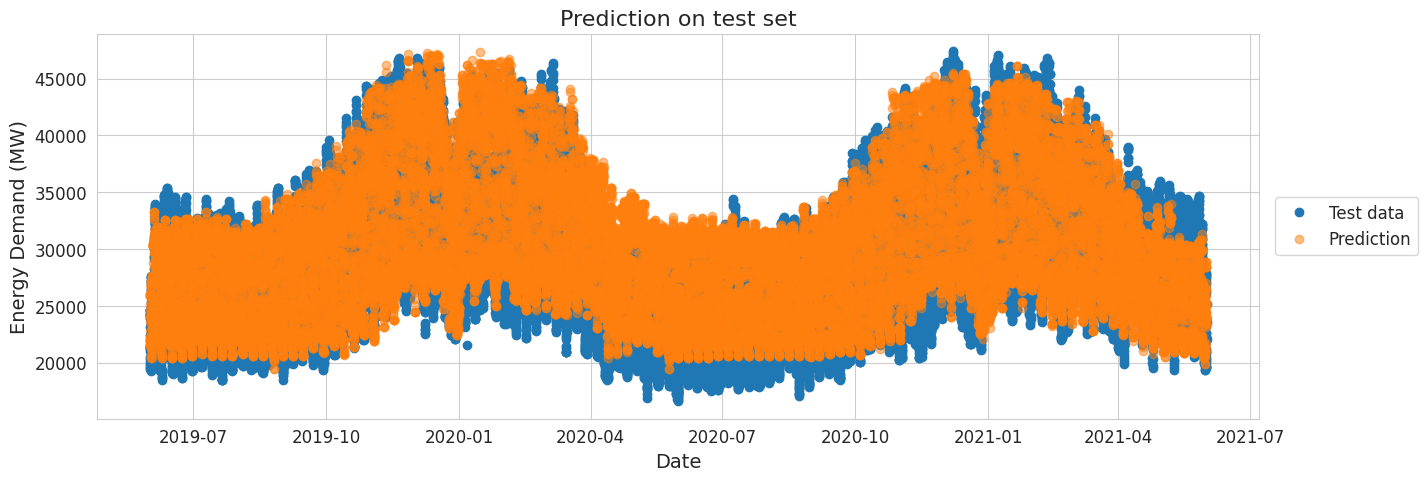

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

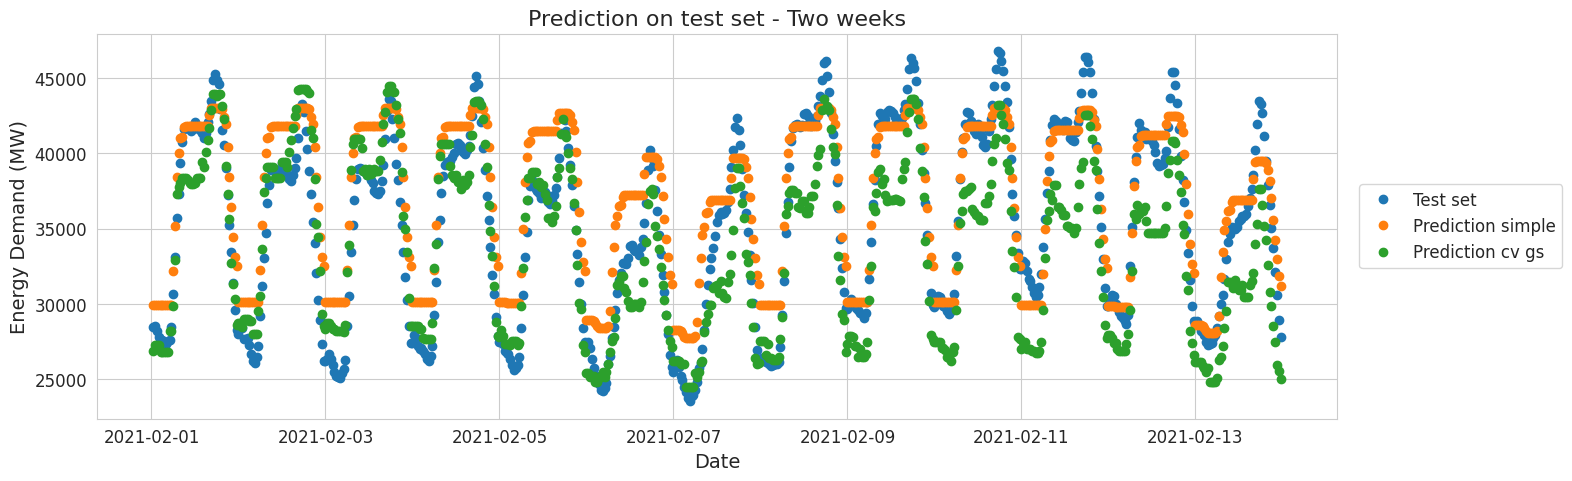

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.70
Root Mean Squared Error of the cross-validated model is: 2744.98 MW


HAE **MODEL**

In [ ]:
# Install required libraries (if not already installed)
!pip install tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Load and preprocess data
def preprocess_data(data):
    """Handle missing values and feature engineering"""
    data.fillna(0, inplace=True)
    return data

# Load dataset
try:
    energy_data = pd.read_csv('/content/historic_demand_2009_2024.csv')
    print("Dataset loaded successfully. Columns:", energy_data.columns.tolist())
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Please check the file path.")

# Ensure the target column exists
target_col = 'tsd'  # 'tsd' is the target column for energy demand
if target_col not in energy_data.columns:
    raise KeyError(f"Target column '{target_col}' not found in the dataset. Available columns: {energy_data.columns.tolist()}")

# Convert 'settlement_date' to datetime and set it as the index
if 'settlement_date' in energy_data.columns:
    energy_data['settlement_date'] = pd.to_datetime(energy_data['settlement_date'])
    energy_data.set_index('settlement_date', inplace=True)

# Preprocess data
energy_data = preprocess_data(energy_data)
energy_data.head()  # Display the first few rows of the dataset

Dataset loaded successfully. Columns: ['Unnamed: 0', 'settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']


Unnamed: 0  settlement_period     nd    tsd  \
settlement_date                                                
2009-01-01                0                  1  37910  38704   
2009-01-01                1                  2  38047  38964   
2009-01-01                2                  3  37380  38651   
2009-01-01                3                  4  36426  37775   
2009-01-01                4                  5  35687  37298   

                 england_wales_demand  embedded_wind_generation  \
settlement_date                                                   
2009-01-01                      33939                        54   
2009-01-01                      34072                        53   
2009-01-01                      33615                        53   
2009-01-01                      32526                        50   
2009-01-01                      31877                        50   

                 embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                      
2009-01-01                         1403                          0   
2009-01-01                         1403                          0   
2009-01-01                         1403                          0   
2009-01-01                         1403                          0   
2009-01-01                         1403                          0   

                 embedded_solar_capacity  non_bm_stor  ...  britned_flow  \
settlement_date                                        ...                 
2009-01-01                             0            0  ...             0   
2009-01-01                             0            0  ...             0   
2009-01-01                             0            0  ...             0   
2009-01-01                             0            0  ...             0   
2009-01-01                             0            0  ...             0   

                 moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
settlement_date                                                    
2009-01-01             -161               0          0       0.0   
2009-01-01             -160               0          0       0.0   
2009-01-01             -160               0          0       0.0   
2009-01-01             -160               0          0       0.0   
2009-01-01             -160               0          0       0.0   

                 eleclink_flow  scottish_transfer  viking_flow  \
settlement_date                                                  
2009-01-01                 0.0                0.0          0.0   
2009-01-01                 0.0                0.0          0.0   
2009-01-01                 0.0                0.0          0.0   
2009-01-01                 0.0                0.0          0.0   
2009-01-01                 0.0                0.0          0.0   

                 greenlink_flow  is_holiday  
settlement_date                              
2009-01-01                  0.0           1  
2009-01-01                  0.0           1  
2009-01-01                  0.0           1  
2009-01-01                  0.0           1  
2009-01-01                  0.0           1  

[5 rows x 23 columns]

In [ ]:
# Temporal Attention Layer
class TemporalAttention(layers.Layer):
    """Temporal attention mechanism"""
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(1, activation='tanh')

    def call(self, inputs):
        score = self.dense(inputs)  # (batch, timesteps, 1)
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)

# Feature Attention Layer
class FeatureAttention(layers.Layer):
    """Feature-wise attention mechanism"""
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(1, activation='tanh')

    def call(self, inputs):
        score = self.dense(inputs)  # (batch, timesteps, features)
        weights = tf.nn.softmax(score, axis=-1)
        return inputs * weights

In [ ]:
# Build 4-layer Hierarchical Attention Enhanced Model
def build_hae_model(input_shape):
    """Build 4-layer Hierarchical Attention Enhanced Model"""
    inputs = layers.Input(shape=input_shape)

    # Layer 1: Feature Attention
    x = FeatureAttention()(inputs)

    # Layer 2: Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Layer 3: Temporal Attention
    x = TemporalAttention()(x)

    # Layer 4: Dense Output
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
# Train and evaluate hAE model
def train_evaluate(data, target_col):
    # Data splitting
    if target_col not in data.columns:
        raise KeyError(f"Column '{target_col}' not found in the dataset. Available columns: {data.columns.tolist()}")

    # Drop non-numeric columns
    data = data.select_dtypes(include=[np.number])

    # Ensure target column is numeric
    data[target_col] = pd.to_numeric(data[target_col], errors='coerce')

    # Handle missing values in the target column
    data.dropna(subset=[target_col], inplace=True)

    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Reshape data for hAE model
    X = X.values.reshape(-1, X.shape[1], 1)  # Reshape for LSTM input (samples, timesteps, features)

    # Train-test split using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=4)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Build and train hAE model
    hae_model = build_hae_model((X.shape[1], 1))
    hae_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

    # Generate predictions
    y_pred = hae_model.predict(X_test)

    return y_test, y_pred, hae_model

# Train and evaluate
y_test, y_pred, hae_model = train_evaluate(energy_data, target_col)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 113s 31ms/step - loss: 1180103040.0000 - val_loss: 835539648.0000
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 143s 31ms/step - loss: 1151214208.0000 - val_loss: 810481280.0000
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 138s 30ms/step - loss: 1120238336.0000 - val_loss: 785860160.0000
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 144s 30ms/step - loss: 1093642624.0000 - val_loss: 761654144.0000
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 140s 30ms/step - loss: 1064962688.0000 - val_loss: 737836736.0000
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 143s 30ms/step - loss: 1036494080.0000 - val_loss: 714422400.0000
Epoch 7/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 104s 30ms/step - loss: 1008348736.0000 - val_loss: 691404544.0000
Epoch 8/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 140s 29ms/step - loss: 981153984.0000 - val_loss: 668780032.0000
Epoch 9/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 102s 29ms/step - loss: 954765824.0000 - val_loss: 646559488.0000
Epoch 10/50
3491/3491 ━━━━━━━━

In [ ]:


# Generate visualization
def generate_visualization(y_test, y_pred, start_date, end_date):
    """Plot actual vs predicted energy demand"""
    # Create a DataFrame for results
    result_frame = pd.DataFrame({'tsd': y_test.index, 'Actual': y_test, 'Predicted': y_pred.flatten()})

    # Convert 'tsd' to datetime if it's not already
    if not np.issubdtype(result_frame['tsd'].dtype, np.datetime64):
        result_frame['tsd'] = pd.to_datetime(result_frame['tsd'])

    # Set 'tsd' as the index
    result_frame.set_index('tsd', inplace=True)

    # Filter for the specified date range
    mask = (result_frame.index >= start_date) & (result_frame.index <= end_date)
    result_frame = result_frame.loc[mask]

    # Debugging: Print the filtered DataFrame
    print("Filtered DataFrame for visualization:")
    print(result_frame)

    # Plot
    if not result_frame.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(result_frame['Actual'], label='Actual')
        plt.plot(result_frame['Predicted'], label='Predicted')
        plt.title(f'Energy Demand Prediction Comparison ({start_date} to {end_date})')
        plt.xlabel('Date')
        plt.ylabel('Energy Demand')
        plt.legend()
        plt.grid(True)
        plt.show()  # Ensure the plot is displayed
    else:
        print("No data to plot for the specified date range.")

# Plot results
start_date = '06-01-2019'
end_date = '06-01-2021'
generate_visualization(y_test, y_pred, start_date, end_date)

Filtered DataFrame for visualization:
Empty DataFrame
Columns: [Actual, Predicted]
Index: []
No data to plot for the specified date range.


In [ ]:
# Calculate metrics
def calculate_metrics(actual, pred):
    """Calculate MAPE and RMSE"""
    mape = mean_absolute_percentage_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")

# Display metrics
print("hAE Model Metrics:")
calculate_metrics(y_test, y_pred)

hAE Model Metrics:
MAPE: 0.22%
RMSE: 8753.53
